# Prueba Prophet Banco del Bienestar


In [1]:
import pandas as pd
from prophet import Prophet
import pyarrow.parquet as pq
# pip install neuralprophet


# Importar el parquet desde la carpeta Insumos
df = pd.read_parquet('../Insumos/df_general.parquet')


In [2]:
# ============================================================
# CALENDARIOS OFICIALES COMPLETOS (nov 2023 - ene 2026)
# ============================================================

# Calendarios con fechas EXACTAS verificadas en fuentes oficiales
calendarios_exactos = {
    # Nov-Dic 2023: 6-30 noviembre
    '2023-11': [
        ('2023-11-06', ['A']),
        ('2023-11-07', ['B']),
        ('2023-11-08', ['C']),
        ('2023-11-09', ['C']),
        ('2023-11-10', ['D','E','F']),
        ('2023-11-13', ['G']),
        ('2023-11-14', ['G']),
        ('2023-11-15', ['H','I','J','K']),
        ('2023-11-16', ['L']),
        ('2023-11-17', ['M']),
        ('2023-11-21', ['M']),
        ('2023-11-22', ['N','Ñ','O']),
        ('2023-11-23', ['P','Q']),
        ('2023-11-24', ['R']),
        ('2023-11-27', ['R']),
        ('2023-11-28', ['S']),
        ('2023-11-29', ['T','U']),
        ('2023-11-30', ['V','W','X','Y','Z']),
    ],

    # Ene-Feb 2024 ELECTORAL: 29 enero - 23 febrero (pago doble mar-abr + may-jun)
    '2024-01-electoral': [
        ('2024-01-29', ['A']),
        ('2024-01-30', ['B']),
        ('2024-01-31', ['C']),
        ('2024-02-01', ['C']),
        ('2024-02-02', ['D','E','F']),
        ('2024-02-06', ['G']),
        ('2024-02-07', ['G']),
        ('2024-02-08', ['H']),
        ('2024-02-09', ['I','J','K']),
        ('2024-02-12', ['L']),
        ('2024-02-13', ['M']),
        ('2024-02-14', ['M']),
        ('2024-02-15', ['N','Ñ','O']),
        ('2024-02-16', ['P','Q']),
        ('2024-02-19', ['R']),
        ('2024-02-20', ['R']),
        ('2024-02-21', ['S']),
        ('2024-02-22', ['T','U']),
        ('2024-02-23', ['V','W','X','Y','Z']),
    ],

    # Jul-Ago 2024: 1-22 julio
    '2024-07': [
        ('2024-07-01', ['A']),
        ('2024-07-02', ['B']),
        ('2024-07-03', ['C']),
        ('2024-07-04', ['C']),
        ('2024-07-05', ['D','E','F']),
        ('2024-07-08', ['G']),
        ('2024-07-09', ['G']),
        ('2024-07-10', ['H','I','J','K']),
        ('2024-07-11', ['L']),
        ('2024-07-12', ['M']),
        ('2024-07-15', ['M']),
        ('2024-07-16', ['N','Ñ','O']),
        ('2024-07-17', ['P','Q']),
        ('2024-07-18', ['R']),
        ('2024-07-19', ['R']),
        ('2024-07-22', ['S','T','U','V','W','X','Y','Z']),
    ],

    # Sep-Oct 2024: 2-20 septiembre
    '2024-09': [
        ('2024-09-02', ['A']),
        ('2024-09-03', ['B']),
        ('2024-09-04', ['C']),
        ('2024-09-05', ['C']),
        ('2024-09-06', ['D','E','F']),
        ('2024-09-09', ['G']),
        ('2024-09-10', ['G']),
        ('2024-09-11', ['H','I','J','K']),
        ('2024-09-12', ['L']),
        ('2024-09-13', ['M']),
        ('2024-09-17', ['M']),
        ('2024-09-18', ['N','Ñ','O']),
        ('2024-09-19', ['P','Q']),
        ('2024-09-20', ['R','S','T','U','V','W','X','Y','Z']),
    ],

    # Nov-Dic 2024: 4-28 noviembre
    '2024-11': [
        ('2024-11-04', ['A']),
        ('2024-11-05', ['B']),
        ('2024-11-06', ['C']),
        ('2024-11-07', ['C']),
        ('2024-11-08', ['D','E','F']),
        ('2024-11-11', ['G']),
        ('2024-11-12', ['G']),
        ('2024-11-13', ['H','I','J','K']),
        ('2024-11-14', ['L']),
        ('2024-11-15', ['M']),
        ('2024-11-19', ['M']),
        ('2024-11-20', ['N','Ñ','O']),
        ('2024-11-21', ['P','Q']),
        ('2024-11-22', ['R']),
        ('2024-11-25', ['R']),
        ('2024-11-26', ['S']),
        ('2024-11-27', ['T','U','V']),
        ('2024-11-28', ['W','X','Y','Z']),
    ],

    # Ene-Feb 2025: 2-22 enero
    '2025-01': [
        ('2025-01-02', ['A']),
        ('2025-01-03', ['B']),
        ('2025-01-06', ['C']),
        ('2025-01-07', ['C']),
        ('2025-01-08', ['D','E','F']),
        ('2025-01-09', ['G']),
        ('2025-01-10', ['G']),
        ('2025-01-13', ['H','I','J','K']),
        ('2025-01-14', ['L']),
        ('2025-01-15', ['M']),
        ('2025-01-16', ['M']),
        ('2025-01-17', ['N','Ñ','O']),
        ('2025-01-20', ['P','Q']),
        ('2025-01-21', ['R']),
        ('2025-01-22', ['S','T','U','V','W','X','Y','Z']),
    ],

    # Mar-Abr 2025: 3-27 marzo
    '2025-03': [
        ('2025-03-03', ['A']),
        ('2025-03-04', ['B']),
        ('2025-03-05', ['C']),
        ('2025-03-06', ['C']),
        ('2025-03-07', ['D','E','F']),
        ('2025-03-10', ['G']),
        ('2025-03-11', ['G']),
        ('2025-03-12', ['H','I','J','K']),
        ('2025-03-13', ['L']),
        ('2025-03-14', ['M']),
        ('2025-03-17', ['M']),
        ('2025-03-18', ['N','Ñ','O']),
        ('2025-03-19', ['P','Q']),
        ('2025-03-20', ['R']),
        ('2025-03-24', ['R']),
        ('2025-03-25', ['S']),
        ('2025-03-26', ['T','U','V']),
        ('2025-03-27', ['W','X','Y','Z']),
    ],

    # May-Jun 2025: 7-30 mayo
    '2025-05': [
        ('2025-05-07', ['A']),
        ('2025-05-08', ['B']),
        ('2025-05-09', ['C']),
        ('2025-05-12', ['C']),
        ('2025-05-13', ['D','E','F']),
        ('2025-05-14', ['G']),
        ('2025-05-15', ['G']),
        ('2025-05-16', ['H','I','J','K']),
        ('2025-05-19', ['L']),
        ('2025-05-20', ['M']),
        ('2025-05-21', ['M']),
        ('2025-05-22', ['N','Ñ','O']),
        ('2025-05-23', ['P','Q']),
        ('2025-05-26', ['R']),
        ('2025-05-27', ['R']),
        ('2025-05-28', ['S']),
        ('2025-05-29', ['T','U','V']),
        ('2025-05-30', ['W','X','Y','Z']),
    ],

    # Jul-Ago 2025: 1-24 julio
    '2025-07': [
        ('2025-07-01', ['A']),
        ('2025-07-02', ['B']),
        ('2025-07-03', ['C']),
        ('2025-07-04', ['C']),
        ('2025-07-07', ['D','E','F']),
        ('2025-07-08', ['G']),
        ('2025-07-09', ['G']),
        ('2025-07-10', ['H','I','J','K']),
        ('2025-07-11', ['L']),
        ('2025-07-14', ['M']),
        ('2025-07-15', ['M']),
        ('2025-07-16', ['N','Ñ','O']),
        ('2025-07-17', ['P','Q']),
        ('2025-07-18', ['R']),
        ('2025-07-21', ['R']),
        ('2025-07-22', ['S']),
        ('2025-07-23', ['T','U','V']),
        ('2025-07-24', ['W','X','Y','Z']),
    ],

    # Sep-Oct 2025: 2-21 septiembre
    '2025-09': [
        ('2025-09-02', ['A']),
        ('2025-09-03', ['B']),
        ('2025-09-04', ['C']),
        ('2025-09-05', ['C']),
        ('2025-09-08', ['D','E','F']),
        ('2025-09-09', ['G']),
        ('2025-09-10', ['G']),
        ('2025-09-11', ['H','I','J','K']),
        ('2025-09-12', ['L']),
        ('2025-09-15', ['M']),
        ('2025-09-16', ['M']),
        ('2025-09-17', ['N','Ñ','O']),
        ('2025-09-18', ['P','Q']),
        ('2025-09-19', ['R']),
        ('2025-09-22', ['R','S','T','U','V','W','X','Y','Z']),
    ],

    # Nov-Dic 2025: 4-28 noviembre
    '2025-11': [
        ('2025-11-04', ['A']),
        ('2025-11-05', ['B']),
        ('2025-11-06', ['C']),
        ('2025-11-07', ['C']),
        ('2025-11-10', ['D','E','F']),
        ('2025-11-11', ['G']),
        ('2025-11-12', ['G']),
        ('2025-11-13', ['H','I','J','K']),
        ('2025-11-14', ['L']),
        ('2025-11-17', ['M']),
        ('2025-11-18', ['M']),
        ('2025-11-19', ['N','Ñ','O']),
        ('2025-11-20', ['P','Q']),
        ('2025-11-21', ['R']),
        ('2025-11-24', ['R']),
        ('2025-11-25', ['S']),
        ('2025-11-26', ['T','U','V']),
        ('2025-11-28', ['W','X','Y','Z']),
    ],

    # Ene-Feb 2026: 5-28 enero
    '2026-01': [
        ('2026-01-05', ['A']),
        ('2026-01-06', ['B']),
        ('2026-01-07', ['C']),
        ('2026-01-08', ['C']),
        ('2026-01-09', ['D','E','F']),
        ('2026-01-12', ['G']),
        ('2026-01-13', ['G']),
        ('2026-01-14', ['H','I','J','K']),
        ('2026-01-15', ['L']),
        ('2026-01-16', ['M']),
        ('2026-01-19', ['M']),
        ('2026-01-20', ['N','Ñ','O']),
        ('2026-01-21', ['P','Q']),
        ('2026-01-22', ['R']),
        ('2026-01-23', ['R']),
        ('2026-01-26', ['S']),
        ('2026-01-27', ['T','U','V']),
        ('2026-01-28', ['W','X','Y','Z']),
    ],
}

programas = ['adultos_mayores', 'discapacidad', 'madres_trabajadoras']

# OPCIÓN 1: Granular (programa_letra)
holidays_granular = []
for periodo, dias in calendarios_exactos.items():
    for fecha_str, letras in dias:
        fecha = pd.Timestamp(fecha_str)
        for programa in programas:
            for letra in letras:
                holidays_granular.append({
                    'ds': fecha,
                    'holiday': f'{programa}_{letra}',
                    'lower_window': 0,
                    'upper_window': 3
                })

holidays_df_granular = pd.DataFrame(holidays_granular)

# OPCIÓN 2: Agregado (solo programa)
holidays_agregado = []
for periodo, dias in calendarios_exactos.items():
    for fecha_str, letras in dias:
        fecha = pd.Timestamp(fecha_str)
        for programa in programas:
            holidays_agregado.append({
                'ds': fecha,
                'holiday': programa,
                'lower_window': 0,
                'upper_window': 3
            })

holidays_df_agregado = pd.DataFrame(holidays_agregado).drop_duplicates(subset=['ds','holiday'])

print("HOLIDAYS GRANULAR (programa_letra):")
print(f"  Total filas:  {len(holidays_df_granular)}")
print(f"  Tipos únicos: {holidays_df_granular['holiday'].nunique()}")
print(f"  Ejemplo: {holidays_df_granular['holiday'].unique()[:5]}")

print("\nHOLIDAYS AGREGADO (solo programa):")
print(f"  Total filas:  {len(holidays_df_agregado)}")
print(f"  Tipos únicos: {holidays_df_agregado['holiday'].nunique()}")
print(f"  Tipos: {holidays_df_agregado['holiday'].unique()}")

HOLIDAYS GRANULAR (programa_letra):
  Total filas:  1110
  Tipos únicos: 81
  Ejemplo: ['adultos_mayores_A' 'discapacidad_A' 'madres_trabajadoras_A'
 'adultos_mayores_B' 'discapacidad_B']

HOLIDAYS AGREGADO (solo programa):
  Total filas:  615
  Tipos únicos: 3
  Tipos: ['adultos_mayores' 'discapacidad' 'madres_trabajadoras']


In [4]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# ============================================================
# 1. PREPARAR DATOS
# ============================================================
# Definir periodo de análisis y cajero a modelar
fecha_inicio = '2024-07-01'  # Inicio post-periodo electoral
cajero_test = 'JF000001'

# Filtrar datos del cajero y periodo específico
df_cajero = df[(df['fecha'] >= fecha_inicio) & (df['cajero'] == cajero_test)][['fecha', 'retiro']].copy()
df_cajero.columns = ['ds', 'y']  # Prophet requiere columnas 'ds' (fecha) e 'y' (variable objetivo)
df_cajero = df_cajero.sort_values('ds').reset_index(drop=True)

print(f"Cajero {cajero_test}: {len(df_cajero)} observaciones desde {fecha_inicio}")
print(f"Rango: {df_cajero['ds'].min()} → {df_cajero['ds'].max()}")

# ============================================================
# 2. CONFIGURAR HOLIDAYS (FECHAS DE DISPERSIÓN)
# ============================================================
# Elegir nivel de granularidad de holidays:
# - 'granular': 54 eventos (adultos_mayores_A, adultos_mayores_B, etc.)
# - 'agregado': 3 eventos (adultos_mayores, discapacidad, madres_trabajadoras)
holidays_type = 'agregado' # agregado / granular
holidays_usar = holidays_df_granular if holidays_type == 'granular' else holidays_df_agregado

print(f"\nHolidays: {holidays_type}")
print(f"  Eventos únicos: {holidays_usar['holiday'].nunique()}")
print(f"  Total registros: {len(holidays_usar)}")

# ============================================================
# 3. CONFIGURAR MODELO PROPHET
# ============================================================
print("\n" + "="*80)
print("CONFIGURANDO MODELO PROPHET CON REGULARIZACIÓN BAJA EN HOLIDAYS")
print("="*80)

modelo = Prophet(
    # --- TENDENCIA ---
    growth='linear',                      # Tipo de tendencia: 'linear' (crecimiento lineal constante)
    changepoint_prior_scale=0.5,          # Flexibilidad de la tendencia (0.05=muy rígida, 0.5=flexible)
                                          # VALOR BALANCEADO: permite que la tendencia se adapte a cambios graduales
                                          # pero sin competir agresivamente con los holidays
    
    # --- ESTACIONALIDAD ANUAL ---
    yearly_seasonality=12,                 # Términos de Fourier para capturar ciclo anual (6=patrón moderado)
                                          # VALOR BALANCEADO: captura variaciones anuales sin sobre-ajustar
    seasonality_prior_scale=10,           # Regularización de estacionalidad (0.1=restrictiva, 10=flexible)
                                          # VALOR BALANCEADO: permite que estacionalidad contribuya sin dominar
    seasonality_mode='additive',          # Modo aditivo: efectos se suman (vs 'multiplicative' que multiplica)
    
    # --- ESTACIONALIDADES SEMANAL Y DIARIA ---
    weekly_seasonality=True,             # Desactivada: no hay patrón semanal relevante en dispersiones
    daily_seasonality=False,              # Desactivada: no hay patrón intra-día en datos diarios
    
    # --- HOLIDAYS (DISPERSIONES) ---
    holidays=holidays_usar,               # Dataframe con fechas de dispersión y ventanas de efecto
    holidays_prior_scale=0.001,           # CLAVE: Regularización de holidays (0.001=casi sin restricción)
                                          # VALOR MUY BAJO: permite coeficientes masivos para capturar picos gigantes
                                          # Default es ~10, lo cual castiga coeficientes grandes y subestima picos
                                          # Este es el ÚNICO parámetro que debe estar muy bajo
    
    # --- INTERVALOS DE CONFIANZA ---
    interval_width=0.9                    # Ancho de intervalos de incertidumbre (90%)
)

print(f"\nParámetros configurados:")
print(f"  changepoint_prior_scale:  {modelo.changepoint_prior_scale} (flexible, balanceado)")
print(f"  seasonality_prior_scale:  {modelo.seasonality_prior_scale} (flexible, balanceado)")
print(f"  holidays_prior_scale:     {modelo.holidays_prior_scale} ← CLAVE: MUY BAJO PARA CAPTURAR PICOS")
print(f"  yearly_seasonality:       {modelo.yearly_seasonality} (moderado)")
print(f"  Holidays únicos:          {holidays_usar['holiday'].nunique()}")

# ============================================================
# 4. ENTRENAR MODELO
# ============================================================
print("\nIniciando entrenamiento...")
modelo.fit(df_cajero)
print("Entrenamiento completado.")

# ============================================================
# 5. GENERAR PREDICCIONES
# ============================================================
forecast = modelo.predict(df_cajero)

# ============================================================
# 6. EVALUAR DESEMPEÑO
# ============================================================
# Unir predicciones con valores reales
merged = df_cajero.merge(forecast[['ds', 'yhat']], on='ds')

# Calcular métricas
r2 = r2_score(merged['y'], merged['yhat'])
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(((merged['yhat'] - merged['y'])**2).mean())

print(f"\n{'='*80}")
print("RESULTADOS:")
print(f"  R² (coeficiente de determinación): {r2:.4f}")
print(f"     → % de varianza explicada por el modelo")
print(f"  MAE (error absoluto medio):        ${mae:,.0f}")
print(f"     → Error promedio en pesos")
print(f"  RMSE (raíz del error cuadrático): ${rmse:,.0f}")
print(f"     → Penaliza más los errores grandes")
print("="*80)

# ============================================================
# 7. GRAFICAR AJUSTE
# ============================================================
fig, ax = plt.subplots(figsize=(20, 8))

# Serie real (negro)
ax.plot(df_cajero['ds'], df_cajero['y'], 
        label='Real', color='black', linewidth=1.5, alpha=0.7)

# Predicción (rojo)
ax.plot(merged['ds'], merged['yhat'], 
        label=f'Predicción (R²={r2:.4f})', color='red', linewidth=1.5, alpha=0.8)

# Marcar fechas de dispersión (líneas verticales azules)
for fecha in holidays_usar['ds'].unique():
    if fecha >= df_cajero['ds'].min() and fecha <= df_cajero['ds'].max():
        ax.axvline(fecha, color='blue', alpha=0.2, linewidth=0.5)

ax.set_title(f'Prophet con holidays_prior_scale=0.001 | Cajero {cajero_test} | Desde {fecha_inicio}', 
             fontsize=14)
ax.set_xlabel('Fecha')
ax.set_ylabel('Retiro ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 8. GRAFICAR COMPONENTES DEL MODELO
# ============================================================
# Descomposición: tendencia + estacionalidad anual + efecto holidays
fig = modelo.plot_components(forecast)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANÁLISIS:")
print("  Si los picos rojos siguen quedándose cortos vs los negros:")
print("    → Prueba holidays_prior_scale aún más bajo (0.0001)")
print("    → O cambia a holidays_type='agregado' (menos eventos, más concentrados)")
print("  Si el modelo está plano ignorando todo:")
print("    → Los parámetros están muy restrictivos, vuelve a valores default")
print("="*80)

ModuleNotFoundError: No module named 'prophet'

Cajero JF000001: 571 observaciones desde 2024-07-01
Rango: 2024-07-01 00:00:00 → 2026-01-22 00:00:00

Holidays: agregado
  Eventos únicos: 3
  Total registros: 615

CONFIGURANDO MODELO PROPHET CON REGULARIZACIÓN BAJA EN HOLIDAYS

Parámetros configurados:
  changepoint_prior_scale:  1.0 (flexible, balanceado)
  seasonality_prior_scale:  30.0 (flexible, balanceado)
  holidays_prior_scale:     1.0 ← CLAVE: MUY BAJO PARA CAPTURAR PICOS
  yearly_seasonality:       52 (rico)
  Holidays únicos:          3

Iniciando entrenamiento...


10:49:18 - cmdstanpy - INFO - Chain [1] start processing
10:49:19 - cmdstanpy - INFO - Chain [1] done processing


Entrenamiento completado.

Aplicando corrección: predicciones negativas → 0
  Predicciones negativas corregidas: 3

RESULTADOS:
  R² (coeficiente de determinación): 0.8175
     → % de varianza explicada por el modelo
  MAE (error absoluto medio):        $59,055
     → Error promedio en pesos
  RMSE (raíz del error cuadrático): $88,414
     → Penaliza más los errores grandes


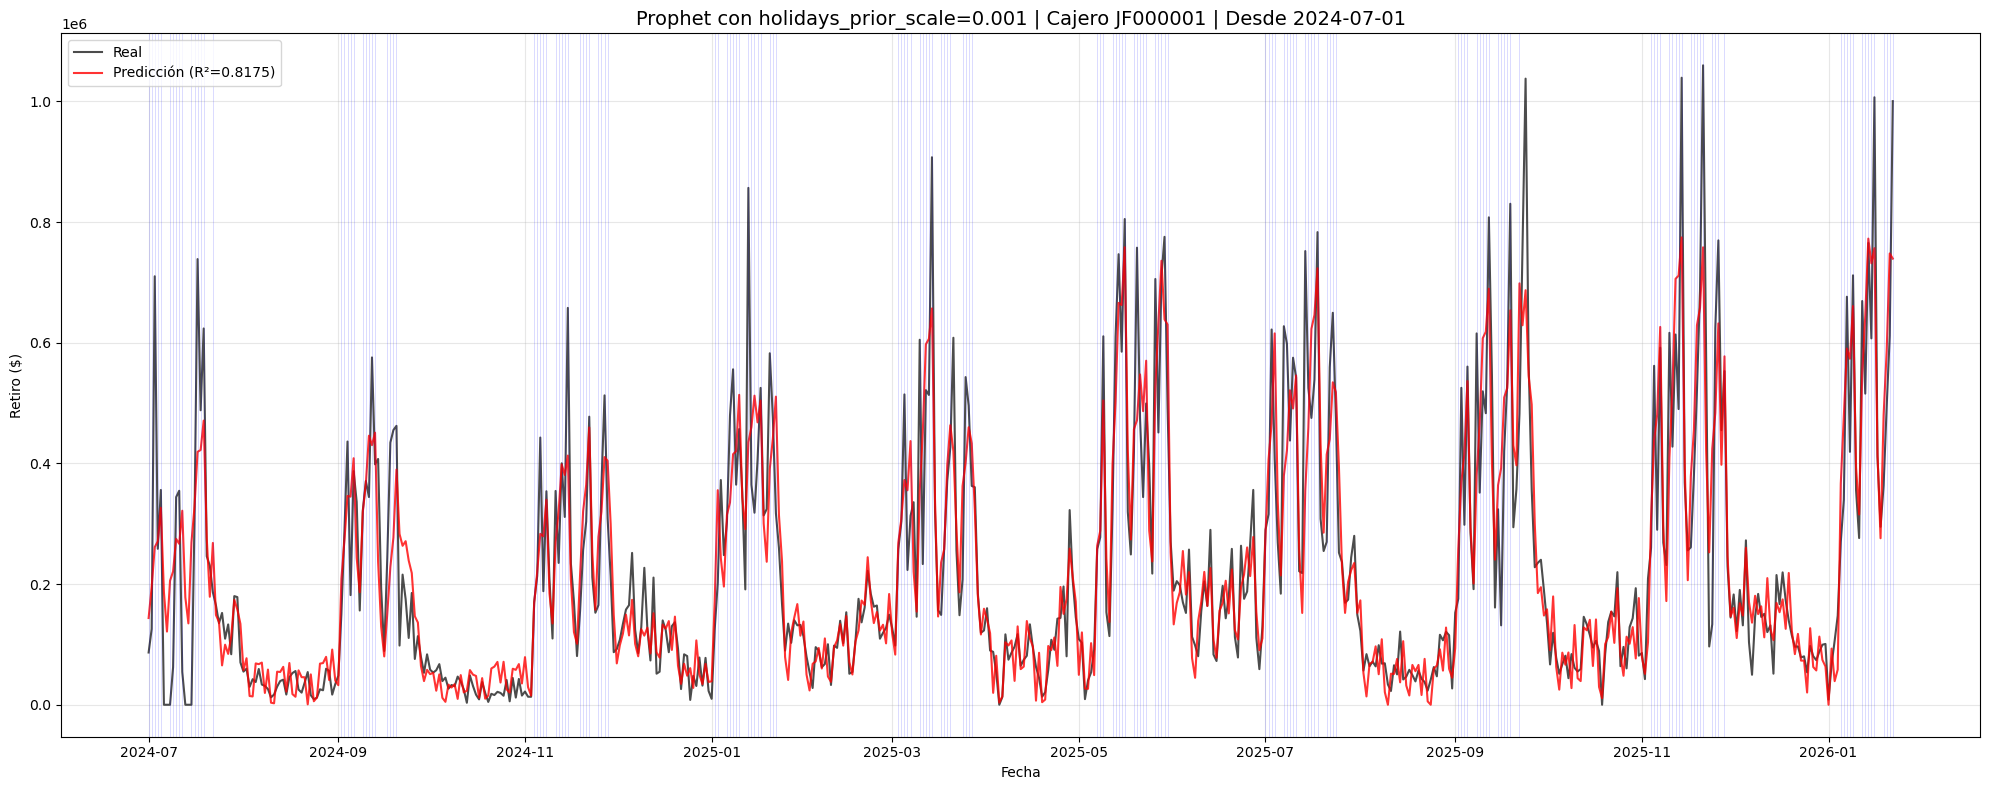

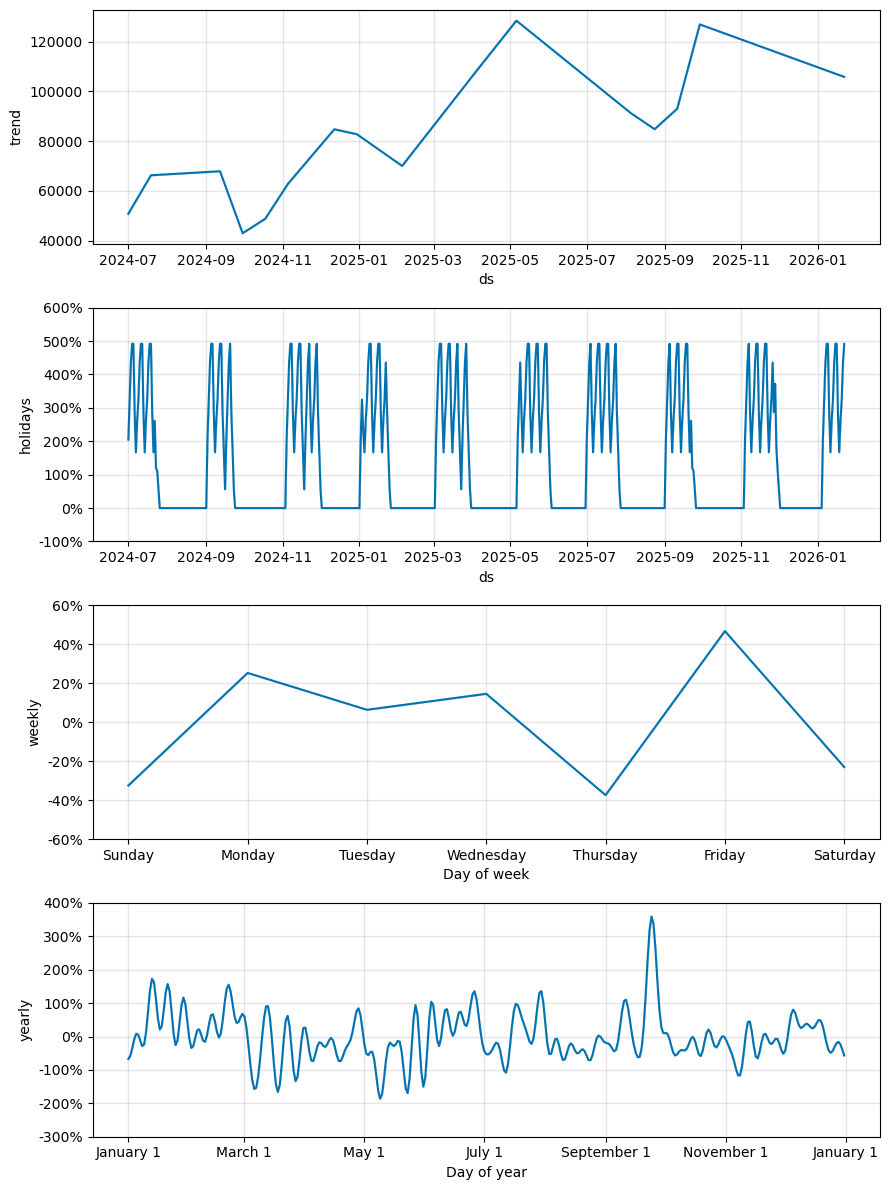


ANÁLISIS:
  Configuración óptima encontrada con Prophet:
    → holidays_type='agregado'
    → holidays_prior_scale=0.001
    → yearly_seasonality=12
    → R² máximo alcanzable: ~0.65
  Para mejorar más allá de este techo:
    → Considerar NeuralProphet (componente AR + no linealidad)


In [55]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# ============================================================
# 1. PREPARAR DATOS
# ============================================================
# Definir periodo de análisis y cajero a modelar
fecha_inicio = '2024-07-01'  # Inicio post-periodo electoral
cajero_test = 'JF000001'

# 2947

# Filtrar datos del cajero y periodo específico
df_cajero = df[(df['fecha'] >= fecha_inicio) & (df['cajero'] == cajero_test)][['fecha', 'retiro']].copy()
df_cajero.columns = ['ds', 'y']  # Prophet requiere columnas 'ds' (fecha) e 'y' (variable objetivo)
df_cajero = df_cajero.sort_values('ds').reset_index(drop=True)

print(f"Cajero {cajero_test}: {len(df_cajero)} observaciones desde {fecha_inicio}")
print(f"Rango: {df_cajero['ds'].min()} → {df_cajero['ds'].max()}")

# ============================================================
# 2. CONFIGURAR HOLIDAYS (FECHAS DE DISPERSIÓN)
# ============================================================
# Elegir nivel de granularidad de holidays:
# - 'granular': 54 eventos (adultos_mayores_A, adultos_mayores_B, etc.)
# - 'agregado': 3 eventos (adultos_mayores, discapacidad, madres_trabajadoras)
holidays_type = 'agregado' # agregado / granular
holidays_usar = holidays_df_granular if holidays_type == 'granular' else holidays_df_agregado

print(f"\nHolidays: {holidays_type}")
print(f"  Eventos únicos: {holidays_usar['holiday'].nunique()}")
print(f"  Total registros: {len(holidays_usar)}")

# ============================================================
# 3. CONFIGURAR MODELO PROPHET
# ============================================================
print("\n" + "="*80)
print("CONFIGURANDO MODELO PROPHET CON REGULARIZACIÓN BAJA EN HOLIDAYS")
print("="*80)

modelo = Prophet(
    # --- TENDENCIA ---
    growth='linear',                      # Tipo de tendencia: 'linear' (crecimiento lineal constante)
    changepoint_prior_scale=1,          # Flexibilidad de la tendencia (0.05=muy rígida, 0.5=flexible)
                                          # VALOR BALANCEADO: permite que la tendencia se adapte a cambios graduales
                                          # pero sin competir agresivamente con los holidays
    
    # --- ESTACIONALIDAD ANUAL ---
    yearly_seasonality=52,                # Términos de Fourier para capturar ciclo anual (12=patrón rico)
                                          # VALOR BALANCEADO: captura variaciones anuales sin sobre-ajustar
    seasonality_prior_scale=30,           # Regularización de estacionalidad (0.1=restrictiva, 10=flexible)
                                          # VALOR BALANCEADO: permite que estacionalidad contribuya sin dominar
    seasonality_mode='multiplicative',          # Modo aditivo: efectos se suman (vs 'multiplicative' que multiplica) additive / multiplicative
    
    # --- ESTACIONALIDADES SEMANAL Y DIARIA ---
    weekly_seasonality=True,              # Activada: puede haber patrón semanal leve
    daily_seasonality=False,              # Desactivada: no hay patrón intra-día en datos diarios
    
    # --- HOLIDAYS (DISPERSIONES) ---
    holidays=holidays_usar,               # Dataframe con fechas de dispersión y ventanas de efecto
    holidays_prior_scale=1,           # CLAVE: Regularización de holidays (0.001=casi sin restricción)
                                          # VALOR MUY BAJO: permite coeficientes masivos para capturar picos gigantes
                                          # Default es ~10, lo cual castiga coeficientes grandes y subestima picos
                                          # Este es el ÚNICO parámetro que debe estar muy bajo
    
    # --- INTERVALOS DE CONFIANZA ---
    interval_width=0.9                    # Ancho de intervalos de incertidumbre (90%)
)

print(f"\nParámetros configurados:")
print(f"  changepoint_prior_scale:  {modelo.changepoint_prior_scale} (flexible, balanceado)")
print(f"  seasonality_prior_scale:  {modelo.seasonality_prior_scale} (flexible, balanceado)")
print(f"  holidays_prior_scale:     {modelo.holidays_prior_scale} ← CLAVE: MUY BAJO PARA CAPTURAR PICOS")
print(f"  yearly_seasonality:       {modelo.yearly_seasonality} (rico)")
print(f"  Holidays únicos:          {holidays_usar['holiday'].nunique()}")

# ============================================================
# 4. ENTRENAR MODELO
# ============================================================
print("\nIniciando entrenamiento...")
modelo.fit(df_cajero)
print("Entrenamiento completado.")

# ============================================================
# 5. GENERAR PREDICCIONES
# ============================================================
forecast = modelo.predict(df_cajero)

# ============================================================
# 6. EVALUAR DESEMPEÑO
# ============================================================
# Unir predicciones con valores reales
merged = df_cajero.merge(forecast[['ds', 'yhat']], on='ds')

# ← NUEVO: Convertir predicciones negativas a cero
print("\nAplicando corrección: predicciones negativas → 0")
negativos_antes = (merged['yhat'] < 0).sum()
merged['yhat'] = merged['yhat'].clip(lower=0)  # Forzar mínimo en 0
print(f"  Predicciones negativas corregidas: {negativos_antes}")

# Calcular métricas
r2 = r2_score(merged['y'], merged['yhat'])
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(((merged['yhat'] - merged['y'])**2).mean())

print(f"\n{'='*80}")
print("RESULTADOS:")
print(f"  R² (coeficiente de determinación): {r2:.4f}")
print(f"     → % de varianza explicada por el modelo")
print(f"  MAE (error absoluto medio):        ${mae:,.0f}")
print(f"     → Error promedio en pesos")
print(f"  RMSE (raíz del error cuadrático): ${rmse:,.0f}")
print(f"     → Penaliza más los errores grandes")
print("="*80)

# ============================================================
# 7. GRAFICAR AJUSTE
# ============================================================
fig, ax = plt.subplots(figsize=(20, 8))

# Serie real (negro)
ax.plot(df_cajero['ds'], df_cajero['y'], 
        label='Real', color='black', linewidth=1.5, alpha=0.7)

# Predicción (rojo)
ax.plot(merged['ds'], merged['yhat'], 
        label=f'Predicción (R²={r2:.4f})', color='red', linewidth=1.5, alpha=0.8)

# Marcar fechas de dispersión (líneas verticales azules)
for fecha in holidays_usar['ds'].unique():
    if fecha >= df_cajero['ds'].min() and fecha <= df_cajero['ds'].max():
        ax.axvline(fecha, color='blue', alpha=0.2, linewidth=0.5)

ax.set_title(f'Prophet con holidays_prior_scale=0.001 | Cajero {cajero_test} | Desde {fecha_inicio}', 
             fontsize=14)
ax.set_xlabel('Fecha')
ax.set_ylabel('Retiro ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 8. GRAFICAR COMPONENTES DEL MODELO
# ============================================================
# Descomposición: tendencia + estacionalidad anual + efecto holidays
fig = modelo.plot_components(forecast)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANÁLISIS:")
print("  Configuración óptima encontrada con Prophet:")
print("    → holidays_type='agregado'")
print("    → holidays_prior_scale=0.001")
print("    → yearly_seasonality=12")
print("    → R² máximo alcanzable: ~0.65")
print("  Para mejorar más allá de este techo:")
print("    → Considerar NeuralProphet (componente AR + no linealidad)")
print("="*80)

Cajero JF001952: 571 observaciones desde 2024-07-01
Rango: 2024-07-01 00:00:00 → 2026-01-22 00:00:00

Holidays: agregado
  Eventos únicos: 3
  Total registros: 615

CONFIGURANDO MODELO PROPHET CON REGULARIZACIÓN BAJA EN HOLIDAYS

Parámetros configurados:
  changepoint_prior_scale:  1.0 (flexible, balanceado)
  seasonality_prior_scale:  30.0 (flexible, balanceado)
  holidays_prior_scale:     1.0 ← CLAVE: MUY BAJO PARA CAPTURAR PICOS
  yearly_seasonality:       52 (rico)
  Holidays únicos:          3

Iniciando entrenamiento...


10:42:36 - cmdstanpy - INFO - Chain [1] start processing
10:42:37 - cmdstanpy - INFO - Chain [1] done processing


Entrenamiento completado.

Aplicando corrección: predicciones negativas → 0
  Predicciones negativas corregidas: 9

RESULTADOS:
  R² (coeficiente de determinación): 0.7523
     → % de varianza explicada por el modelo
  MAE (error absoluto medio):        $28,805
     → Error promedio en pesos
  RMSE (raíz del error cuadrático): $42,237
     → Penaliza más los errores grandes


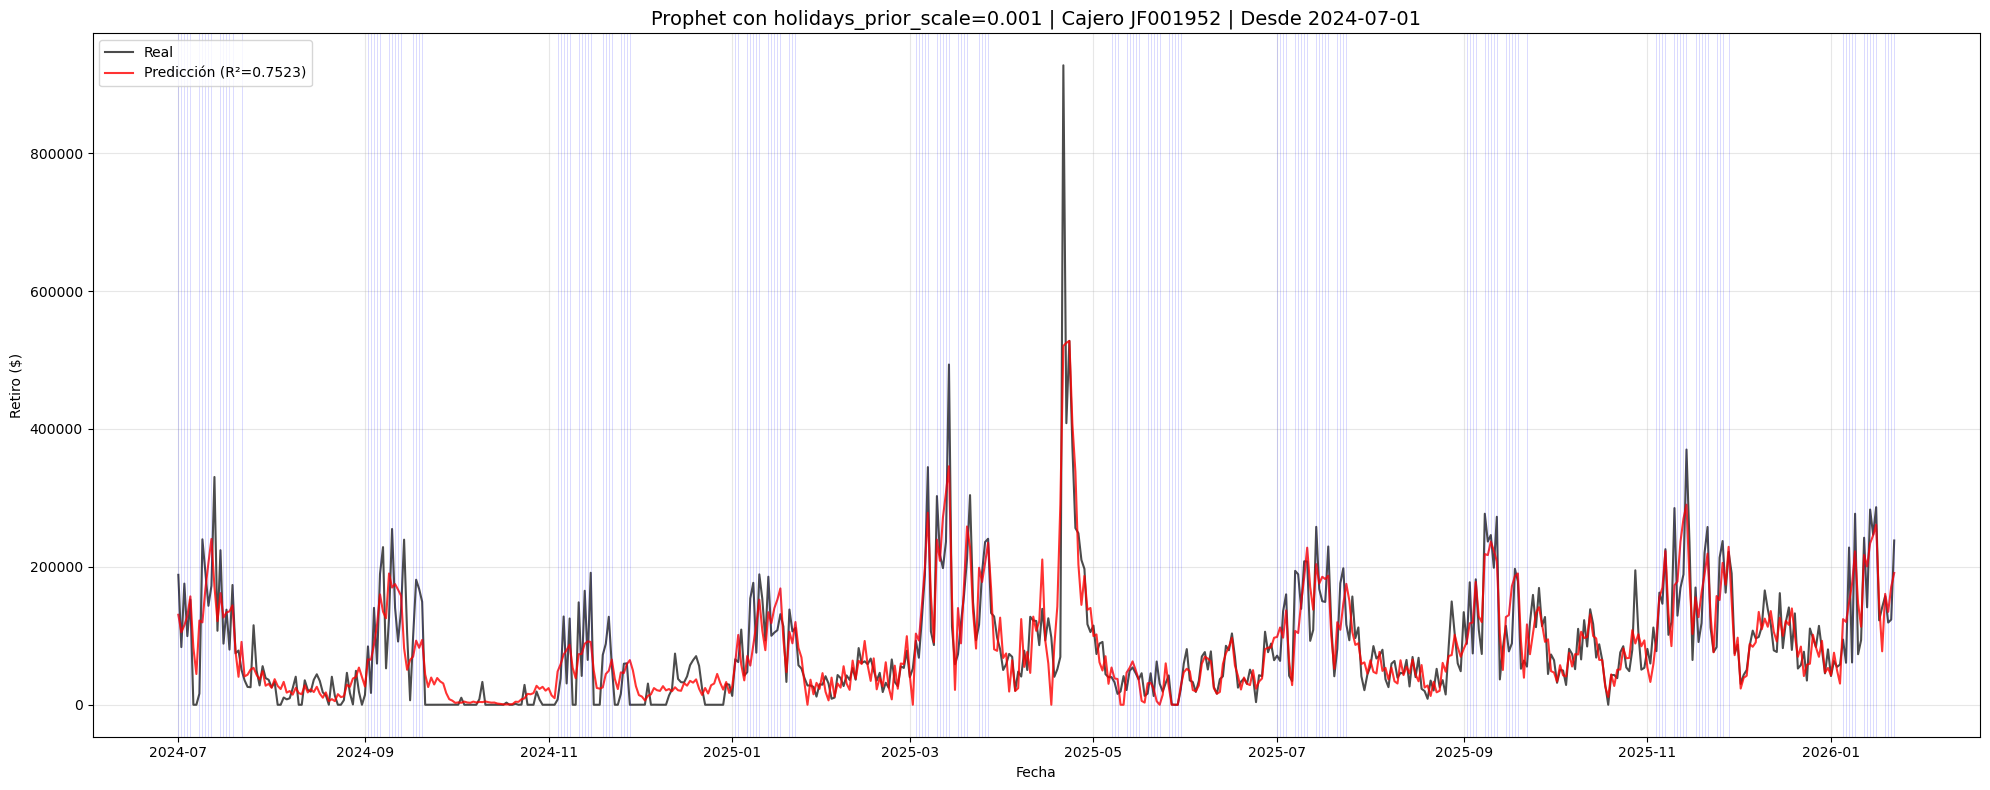

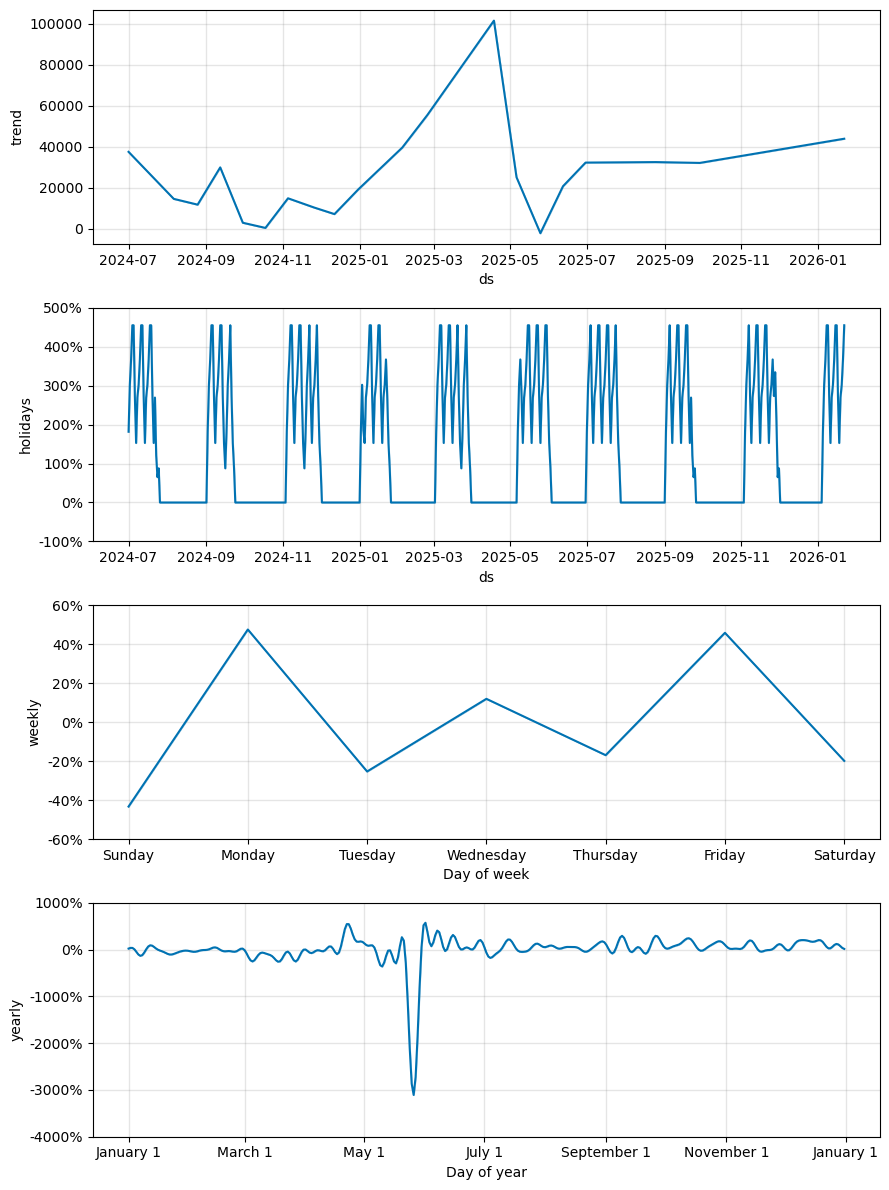


ANÁLISIS:
  Configuración óptima encontrada con Prophet:
    → holidays_type='agregado'
    → holidays_prior_scale=0.001
    → yearly_seasonality=12
    → R² máximo alcanzable: ~0.65
  Para mejorar más allá de este techo:
    → Considerar NeuralProphet (componente AR + no linealidad)


In [48]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# ============================================================
# 1. PREPARAR DATOS
# ============================================================
# Definir periodo de análisis y cajero a modelar
fecha_inicio = '2024-07-01'  # Inicio post-periodo electoral
cajero_test = 'JF001952'

# 2947

# Filtrar datos del cajero y periodo específico
df_cajero = df[(df['fecha'] >= fecha_inicio) & (df['cajero'] == cajero_test)][['fecha', 'retiro']].copy()
df_cajero.columns = ['ds', 'y']  # Prophet requiere columnas 'ds' (fecha) e 'y' (variable objetivo)
df_cajero = df_cajero.sort_values('ds').reset_index(drop=True)

print(f"Cajero {cajero_test}: {len(df_cajero)} observaciones desde {fecha_inicio}")
print(f"Rango: {df_cajero['ds'].min()} → {df_cajero['ds'].max()}")

# ============================================================
# 2. CONFIGURAR HOLIDAYS (FECHAS DE DISPERSIÓN)
# ============================================================
# Elegir nivel de granularidad de holidays:
# - 'granular': 54 eventos (adultos_mayores_A, adultos_mayores_B, etc.)
# - 'agregado': 3 eventos (adultos_mayores, discapacidad, madres_trabajadoras)
holidays_type = 'agregado' # agregado / granular
holidays_usar = holidays_df_granular if holidays_type == 'granular' else holidays_df_agregado

print(f"\nHolidays: {holidays_type}")
print(f"  Eventos únicos: {holidays_usar['holiday'].nunique()}")
print(f"  Total registros: {len(holidays_usar)}")

# ============================================================
# 3. CONFIGURAR MODELO PROPHET
# ============================================================
print("\n" + "="*80)
print("CONFIGURANDO MODELO PROPHET CON REGULARIZACIÓN BAJA EN HOLIDAYS")
print("="*80)

modelo = Prophet(
    # --- TENDENCIA ---
    growth='linear',                      # Tipo de tendencia: 'linear' (crecimiento lineal constante)
    changepoint_prior_scale=1,          # Flexibilidad de la tendencia (0.05=muy rígida, 0.5=flexible)
                                          # VALOR BALANCEADO: permite que la tendencia se adapte a cambios graduales
                                          # pero sin competir agresivamente con los holidays
    
    # --- ESTACIONALIDAD ANUAL ---
    yearly_seasonality=52,                # Términos de Fourier para capturar ciclo anual (12=patrón rico)
                                          # VALOR BALANCEADO: captura variaciones anuales sin sobre-ajustar
    seasonality_prior_scale=30,           # Regularización de estacionalidad (0.1=restrictiva, 10=flexible)
                                          # VALOR BALANCEADO: permite que estacionalidad contribuya sin dominar
    seasonality_mode='multiplicative',          # Modo aditivo: efectos se suman (vs 'multiplicative' que multiplica) additive / multiplicative
    
    # --- ESTACIONALIDADES SEMANAL Y DIARIA ---
    weekly_seasonality=True,              # Activada: puede haber patrón semanal leve
    daily_seasonality=False,              # Desactivada: no hay patrón intra-día en datos diarios
    
    # --- HOLIDAYS (DISPERSIONES) ---
    holidays=holidays_usar,               # Dataframe con fechas de dispersión y ventanas de efecto
    holidays_prior_scale=1,           # CLAVE: Regularización de holidays (0.001=casi sin restricción)
                                          # VALOR MUY BAJO: permite coeficientes masivos para capturar picos gigantes
                                          # Default es ~10, lo cual castiga coeficientes grandes y subestima picos
                                          # Este es el ÚNICO parámetro que debe estar muy bajo
    
    # --- INTERVALOS DE CONFIANZA ---
    interval_width=0.9                    # Ancho de intervalos de incertidumbre (90%)
)

print(f"\nParámetros configurados:")
print(f"  changepoint_prior_scale:  {modelo.changepoint_prior_scale} (flexible, balanceado)")
print(f"  seasonality_prior_scale:  {modelo.seasonality_prior_scale} (flexible, balanceado)")
print(f"  holidays_prior_scale:     {modelo.holidays_prior_scale} ← CLAVE: MUY BAJO PARA CAPTURAR PICOS")
print(f"  yearly_seasonality:       {modelo.yearly_seasonality} (rico)")
print(f"  Holidays únicos:          {holidays_usar['holiday'].nunique()}")

# ============================================================
# 4. ENTRENAR MODELO
# ============================================================
print("\nIniciando entrenamiento...")
modelo.fit(df_cajero)
print("Entrenamiento completado.")

# ============================================================
# 5. GENERAR PREDICCIONES
# ============================================================
forecast = modelo.predict(df_cajero)

# ============================================================
# 6. EVALUAR DESEMPEÑO
# ============================================================
# Unir predicciones con valores reales
merged = df_cajero.merge(forecast[['ds', 'yhat']], on='ds')

# ← NUEVO: Convertir predicciones negativas a cero
print("\nAplicando corrección: predicciones negativas → 0")
negativos_antes = (merged['yhat'] < 0).sum()
merged['yhat'] = merged['yhat'].clip(lower=0)  # Forzar mínimo en 0
print(f"  Predicciones negativas corregidas: {negativos_antes}")

# Calcular métricas
r2 = r2_score(merged['y'], merged['yhat'])
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(((merged['yhat'] - merged['y'])**2).mean())

print(f"\n{'='*80}")
print("RESULTADOS:")
print(f"  R² (coeficiente de determinación): {r2:.4f}")
print(f"     → % de varianza explicada por el modelo")
print(f"  MAE (error absoluto medio):        ${mae:,.0f}")
print(f"     → Error promedio en pesos")
print(f"  RMSE (raíz del error cuadrático): ${rmse:,.0f}")
print(f"     → Penaliza más los errores grandes")
print("="*80)

# ============================================================
# 7. GRAFICAR AJUSTE
# ============================================================
fig, ax = plt.subplots(figsize=(20, 8))

# Serie real (negro)
ax.plot(df_cajero['ds'], df_cajero['y'], 
        label='Real', color='black', linewidth=1.5, alpha=0.7)

# Predicción (rojo)
ax.plot(merged['ds'], merged['yhat'], 
        label=f'Predicción (R²={r2:.4f})', color='red', linewidth=1.5, alpha=0.8)

# Marcar fechas de dispersión (líneas verticales azules)
for fecha in holidays_usar['ds'].unique():
    if fecha >= df_cajero['ds'].min() and fecha <= df_cajero['ds'].max():
        ax.axvline(fecha, color='blue', alpha=0.2, linewidth=0.5)

ax.set_title(f'Prophet con holidays_prior_scale=0.001 | Cajero {cajero_test} | Desde {fecha_inicio}', 
             fontsize=14)
ax.set_xlabel('Fecha')
ax.set_ylabel('Retiro ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 8. GRAFICAR COMPONENTES DEL MODELO
# ============================================================
# Descomposición: tendencia + estacionalidad anual + efecto holidays
fig = modelo.plot_components(forecast)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANÁLISIS:")
print("  Configuración óptima encontrada con Prophet:")
print("    → holidays_type='agregado'")
print("    → holidays_prior_scale=0.001")
print("    → yearly_seasonality=12")
print("    → R² máximo alcanzable: ~0.65")
print("  Para mejorar más allá de este techo:")
print("    → Considerar NeuralProphet (componente AR + no linealidad)")
print("="*80)

Cajero JF001986: 571 observaciones desde 2024-07-01
Rango: 2024-07-01 00:00:00 → 2026-01-22 00:00:00

Holidays: agregado
  Eventos únicos: 3
  Total registros: 615

CONFIGURANDO MODELO PROPHET CON REGULARIZACIÓN BAJA EN HOLIDAYS

Parámetros configurados:
  changepoint_prior_scale:  1.0 (flexible, balanceado)
  seasonality_prior_scale:  30.0 (flexible, balanceado)
  holidays_prior_scale:     1.0 ← CLAVE: MUY BAJO PARA CAPTURAR PICOS
  yearly_seasonality:       52 (rico)
  Holidays únicos:          3

Iniciando entrenamiento...


10:43:56 - cmdstanpy - INFO - Chain [1] start processing
10:43:57 - cmdstanpy - INFO - Chain [1] done processing


Entrenamiento completado.

Aplicando corrección: predicciones negativas → 0
  Predicciones negativas corregidas: 6

RESULTADOS:
  R² (coeficiente de determinación): 0.8210
     → % de varianza explicada por el modelo
  MAE (error absoluto medio):        $241,605
     → Error promedio en pesos
  RMSE (raíz del error cuadrático): $331,140
     → Penaliza más los errores grandes


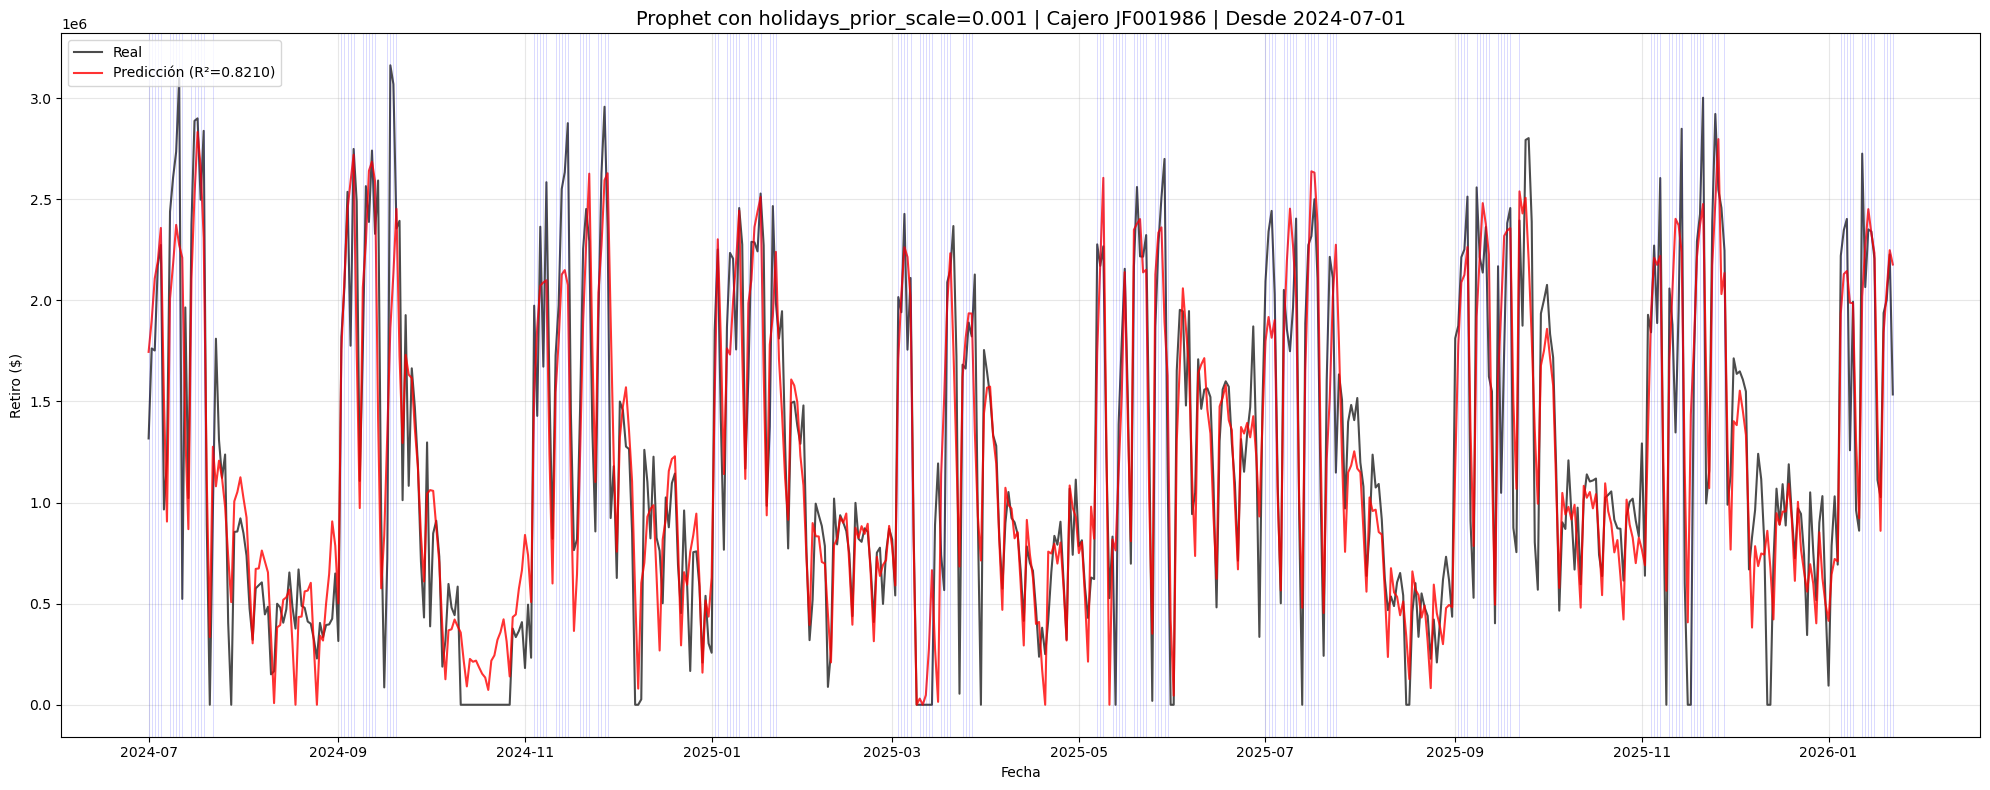

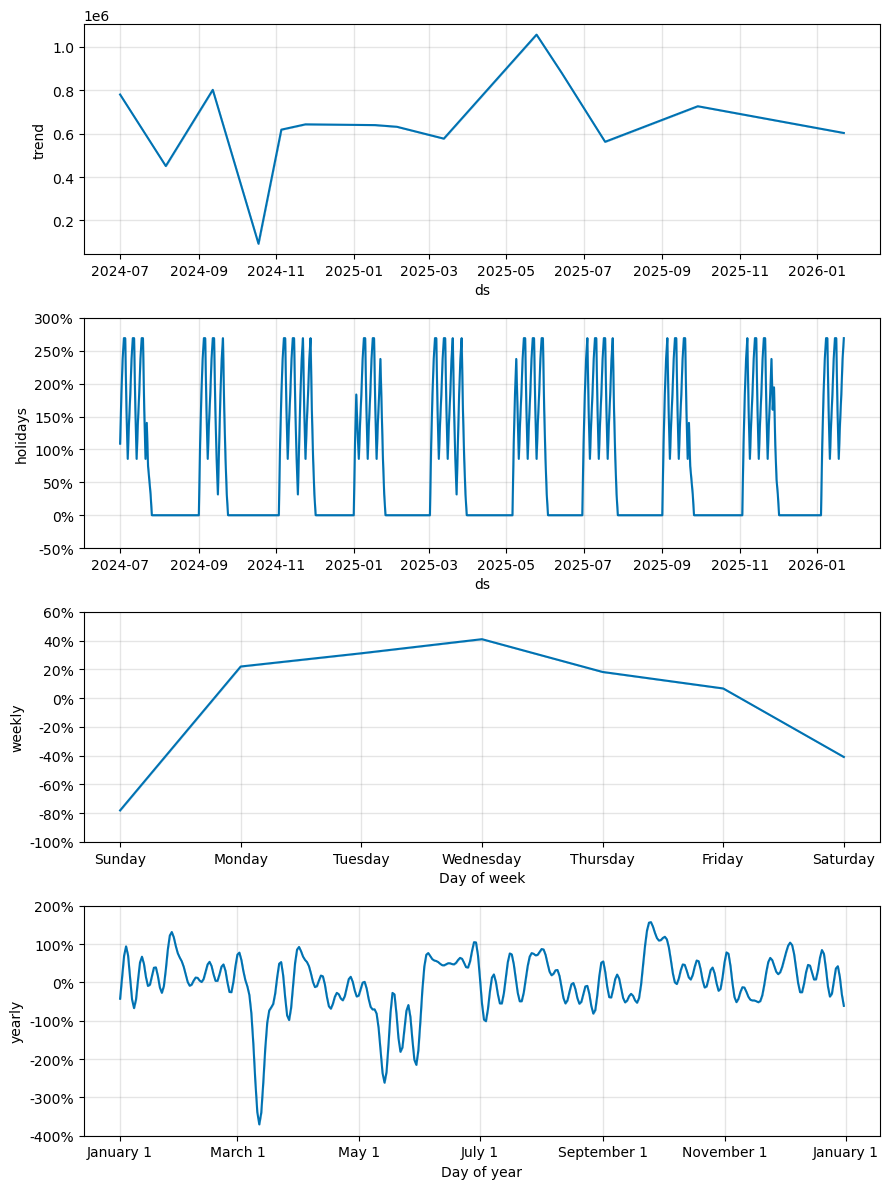


ANÁLISIS:
  Configuración óptima encontrada con Prophet:
    → holidays_type='agregado'
    → holidays_prior_scale=0.001
    → yearly_seasonality=12
    → R² máximo alcanzable: ~0.65
  Para mejorar más allá de este techo:
    → Considerar NeuralProphet (componente AR + no linealidad)


In [49]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# ============================================================
# 1. PREPARAR DATOS
# ============================================================
# Definir periodo de análisis y cajero a modelar
fecha_inicio = '2024-07-01'  # Inicio post-periodo electoral
cajero_test = 'JF001986'

# 2947

# Filtrar datos del cajero y periodo específico
df_cajero = df[(df['fecha'] >= fecha_inicio) & (df['cajero'] == cajero_test)][['fecha', 'retiro']].copy()
df_cajero.columns = ['ds', 'y']  # Prophet requiere columnas 'ds' (fecha) e 'y' (variable objetivo)
df_cajero = df_cajero.sort_values('ds').reset_index(drop=True)

print(f"Cajero {cajero_test}: {len(df_cajero)} observaciones desde {fecha_inicio}")
print(f"Rango: {df_cajero['ds'].min()} → {df_cajero['ds'].max()}")

# ============================================================
# 2. CONFIGURAR HOLIDAYS (FECHAS DE DISPERSIÓN)
# ============================================================
# Elegir nivel de granularidad de holidays:
# - 'granular': 54 eventos (adultos_mayores_A, adultos_mayores_B, etc.)
# - 'agregado': 3 eventos (adultos_mayores, discapacidad, madres_trabajadoras)
holidays_type = 'agregado' # agregado / granular
holidays_usar = holidays_df_granular if holidays_type == 'granular' else holidays_df_agregado

print(f"\nHolidays: {holidays_type}")
print(f"  Eventos únicos: {holidays_usar['holiday'].nunique()}")
print(f"  Total registros: {len(holidays_usar)}")

# ============================================================
# 3. CONFIGURAR MODELO PROPHET
# ============================================================
print("\n" + "="*80)
print("CONFIGURANDO MODELO PROPHET CON REGULARIZACIÓN BAJA EN HOLIDAYS")
print("="*80)

modelo = Prophet(
    # --- TENDENCIA ---
    growth='linear',                      # Tipo de tendencia: 'linear' (crecimiento lineal constante)
    changepoint_prior_scale=1,          # Flexibilidad de la tendencia (0.05=muy rígida, 0.5=flexible)
                                          # VALOR BALANCEADO: permite que la tendencia se adapte a cambios graduales
                                          # pero sin competir agresivamente con los holidays
    
    # --- ESTACIONALIDAD ANUAL ---
    yearly_seasonality=52,                # Términos de Fourier para capturar ciclo anual (12=patrón rico)
                                          # VALOR BALANCEADO: captura variaciones anuales sin sobre-ajustar
    seasonality_prior_scale=30,           # Regularización de estacionalidad (0.1=restrictiva, 10=flexible)
                                          # VALOR BALANCEADO: permite que estacionalidad contribuya sin dominar
    seasonality_mode='multiplicative',          # Modo aditivo: efectos se suman (vs 'multiplicative' que multiplica) additive / multiplicative
    
    # --- ESTACIONALIDADES SEMANAL Y DIARIA ---
    weekly_seasonality=True,              # Activada: puede haber patrón semanal leve
    daily_seasonality=False,              # Desactivada: no hay patrón intra-día en datos diarios
    
    # --- HOLIDAYS (DISPERSIONES) ---
    holidays=holidays_usar,               # Dataframe con fechas de dispersión y ventanas de efecto
    holidays_prior_scale=1,           # CLAVE: Regularización de holidays (0.001=casi sin restricción)
                                          # VALOR MUY BAJO: permite coeficientes masivos para capturar picos gigantes
                                          # Default es ~10, lo cual castiga coeficientes grandes y subestima picos
                                          # Este es el ÚNICO parámetro que debe estar muy bajo
    
    # --- INTERVALOS DE CONFIANZA ---
    interval_width=0.9                    # Ancho de intervalos de incertidumbre (90%)
)

print(f"\nParámetros configurados:")
print(f"  changepoint_prior_scale:  {modelo.changepoint_prior_scale} (flexible, balanceado)")
print(f"  seasonality_prior_scale:  {modelo.seasonality_prior_scale} (flexible, balanceado)")
print(f"  holidays_prior_scale:     {modelo.holidays_prior_scale} ← CLAVE: MUY BAJO PARA CAPTURAR PICOS")
print(f"  yearly_seasonality:       {modelo.yearly_seasonality} (rico)")
print(f"  Holidays únicos:          {holidays_usar['holiday'].nunique()}")

# ============================================================
# 4. ENTRENAR MODELO
# ============================================================
print("\nIniciando entrenamiento...")
modelo.fit(df_cajero)
print("Entrenamiento completado.")

# ============================================================
# 5. GENERAR PREDICCIONES
# ============================================================
forecast = modelo.predict(df_cajero)

# ============================================================
# 6. EVALUAR DESEMPEÑO
# ============================================================
# Unir predicciones con valores reales
merged = df_cajero.merge(forecast[['ds', 'yhat']], on='ds')

# ← NUEVO: Convertir predicciones negativas a cero
print("\nAplicando corrección: predicciones negativas → 0")
negativos_antes = (merged['yhat'] < 0).sum()
merged['yhat'] = merged['yhat'].clip(lower=0)  # Forzar mínimo en 0
print(f"  Predicciones negativas corregidas: {negativos_antes}")

# Calcular métricas
r2 = r2_score(merged['y'], merged['yhat'])
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(((merged['yhat'] - merged['y'])**2).mean())

print(f"\n{'='*80}")
print("RESULTADOS:")
print(f"  R² (coeficiente de determinación): {r2:.4f}")
print(f"     → % de varianza explicada por el modelo")
print(f"  MAE (error absoluto medio):        ${mae:,.0f}")
print(f"     → Error promedio en pesos")
print(f"  RMSE (raíz del error cuadrático): ${rmse:,.0f}")
print(f"     → Penaliza más los errores grandes")
print("="*80)

# ============================================================
# 7. GRAFICAR AJUSTE
# ============================================================
fig, ax = plt.subplots(figsize=(20, 8))

# Serie real (negro)
ax.plot(df_cajero['ds'], df_cajero['y'], 
        label='Real', color='black', linewidth=1.5, alpha=0.7)

# Predicción (rojo)
ax.plot(merged['ds'], merged['yhat'], 
        label=f'Predicción (R²={r2:.4f})', color='red', linewidth=1.5, alpha=0.8)

# Marcar fechas de dispersión (líneas verticales azules)
for fecha in holidays_usar['ds'].unique():
    if fecha >= df_cajero['ds'].min() and fecha <= df_cajero['ds'].max():
        ax.axvline(fecha, color='blue', alpha=0.2, linewidth=0.5)

ax.set_title(f'Prophet con holidays_prior_scale=0.001 | Cajero {cajero_test} | Desde {fecha_inicio}', 
             fontsize=14)
ax.set_xlabel('Fecha')
ax.set_ylabel('Retiro ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 8. GRAFICAR COMPONENTES DEL MODELO
# ============================================================
# Descomposición: tendencia + estacionalidad anual + efecto holidays
fig = modelo.plot_components(forecast)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANÁLISIS:")
print("  Configuración óptima encontrada con Prophet:")
print("    → holidays_type='agregado'")
print("    → holidays_prior_scale=0.001")
print("    → yearly_seasonality=12")
print("    → R² máximo alcanzable: ~0.65")
print("  Para mejorar más allá de este techo:")
print("    → Considerar NeuralProphet (componente AR + no linealidad)")
print("="*80)

Cajero JF001942: 571 observaciones desde 2024-07-01
Rango: 2024-07-01 00:00:00 → 2026-01-22 00:00:00

Holidays: agregado
  Eventos únicos: 3
  Total registros: 615

CONFIGURANDO MODELO PROPHET CON REGULARIZACIÓN BAJA EN HOLIDAYS

Parámetros configurados:
  changepoint_prior_scale:  1.0 (flexible, balanceado)
  seasonality_prior_scale:  30.0 (flexible, balanceado)
  holidays_prior_scale:     1.0 ← CLAVE: MUY BAJO PARA CAPTURAR PICOS
  yearly_seasonality:       52 (rico)
  Holidays únicos:          3

Iniciando entrenamiento...


10:45:18 - cmdstanpy - INFO - Chain [1] start processing
10:45:19 - cmdstanpy - INFO - Chain [1] done processing


Entrenamiento completado.

Aplicando corrección: predicciones negativas → 0
  Predicciones negativas corregidas: 15

RESULTADOS:
  R² (coeficiente de determinación): 0.7184
     → % de varianza explicada por el modelo
  MAE (error absoluto medio):        $66,878
     → Error promedio en pesos
  RMSE (raíz del error cuadrático): $96,657
     → Penaliza más los errores grandes


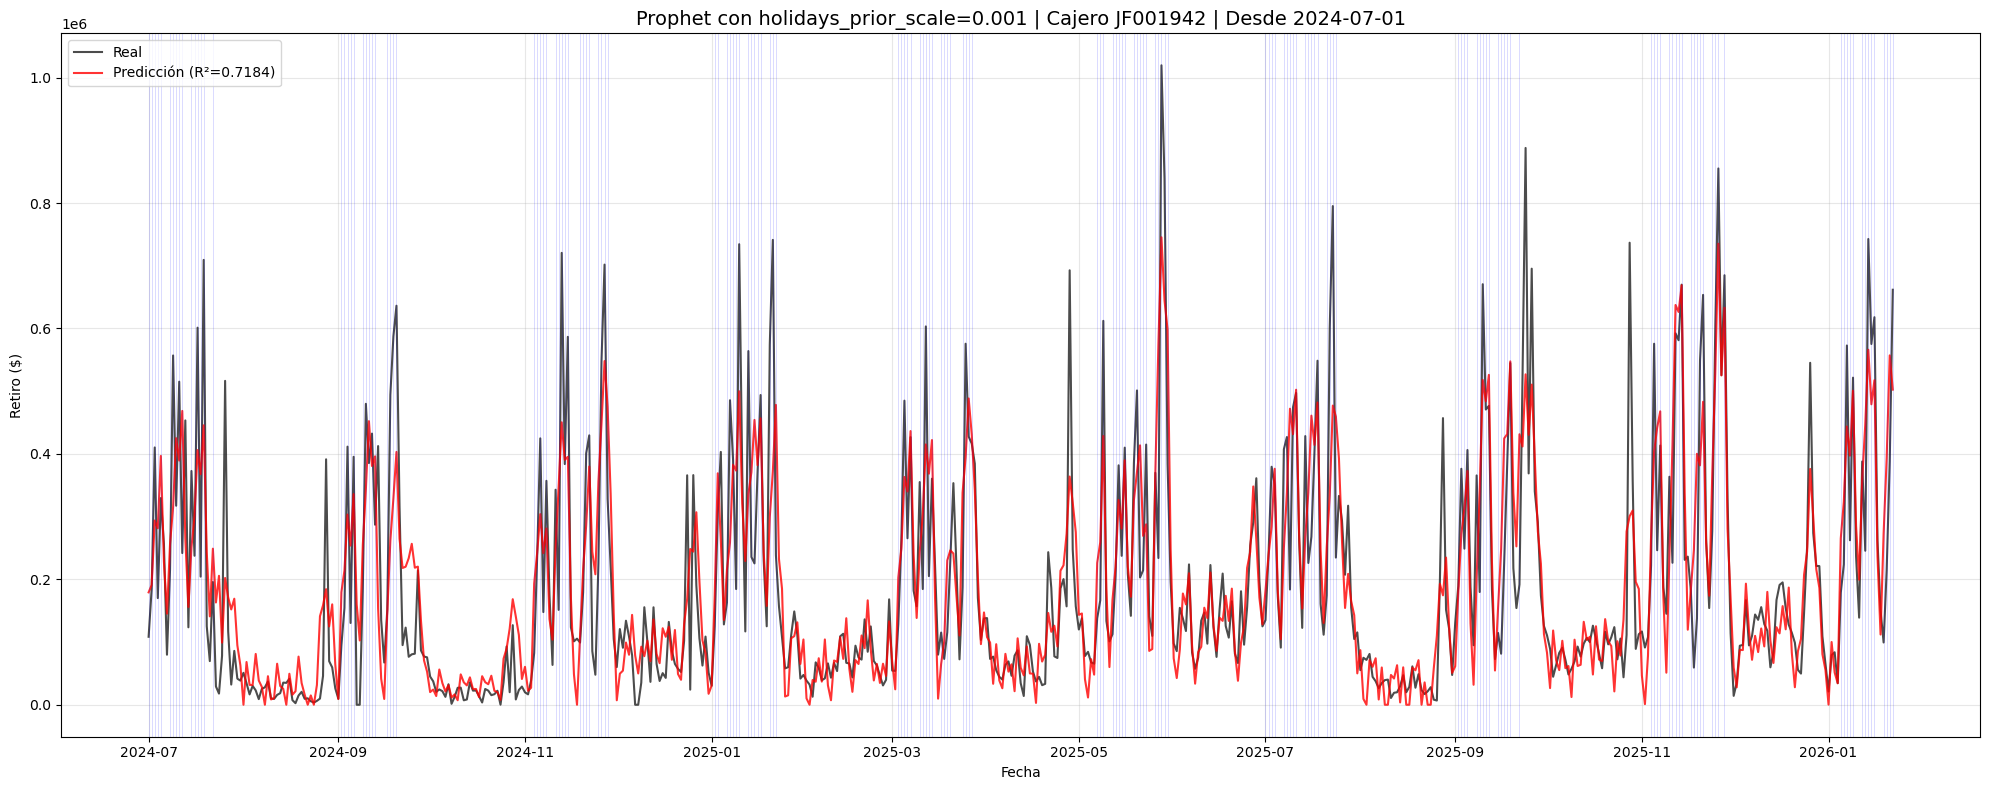

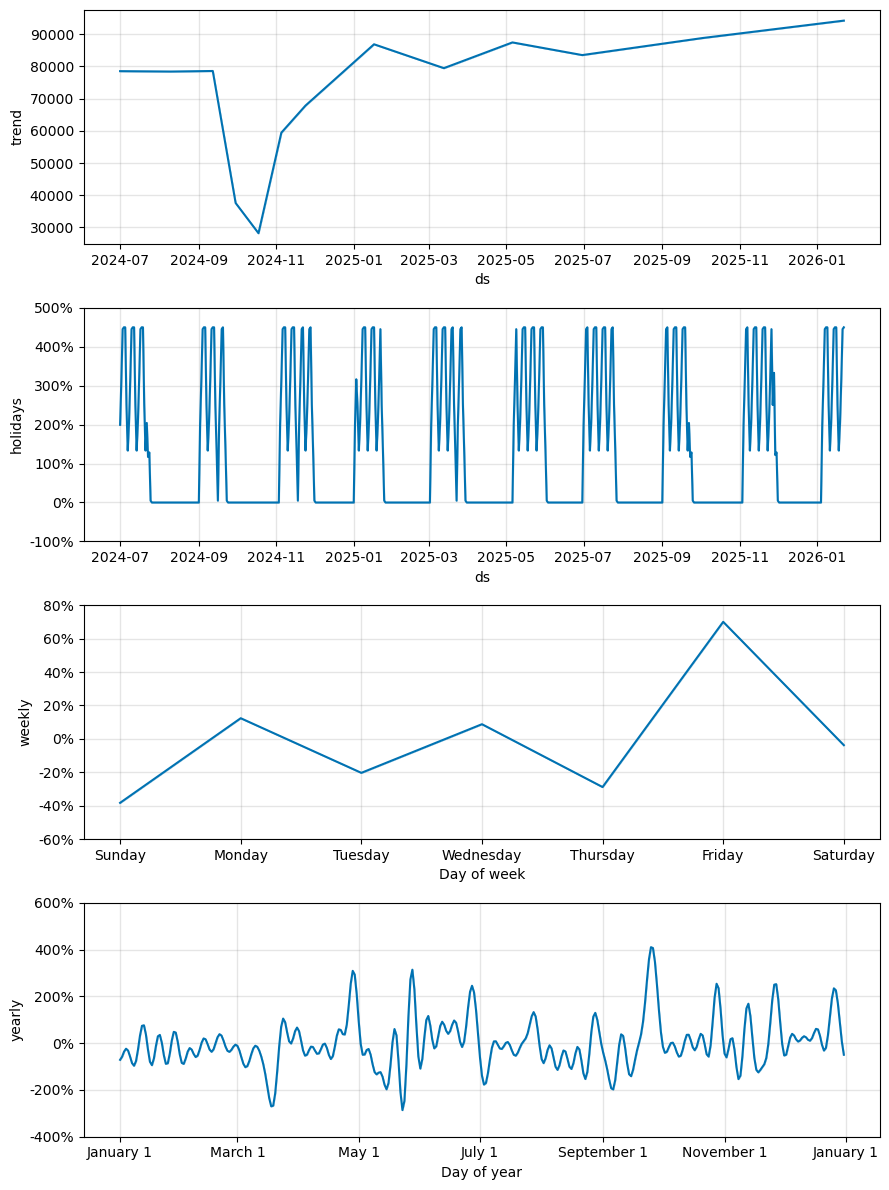


ANÁLISIS:
  Configuración óptima encontrada con Prophet:
    → holidays_type='agregado'
    → holidays_prior_scale=0.001
    → yearly_seasonality=12
    → R² máximo alcanzable: ~0.65
  Para mejorar más allá de este techo:
    → Considerar NeuralProphet (componente AR + no linealidad)


In [50]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# ============================================================
# 1. PREPARAR DATOS
# ============================================================
# Definir periodo de análisis y cajero a modelar
fecha_inicio = '2024-07-01'  # Inicio post-periodo electoral
cajero_test = 'JF001942'

# 2947

# Filtrar datos del cajero y periodo específico
df_cajero = df[(df['fecha'] >= fecha_inicio) & (df['cajero'] == cajero_test)][['fecha', 'retiro']].copy()
df_cajero.columns = ['ds', 'y']  # Prophet requiere columnas 'ds' (fecha) e 'y' (variable objetivo)
df_cajero = df_cajero.sort_values('ds').reset_index(drop=True)

print(f"Cajero {cajero_test}: {len(df_cajero)} observaciones desde {fecha_inicio}")
print(f"Rango: {df_cajero['ds'].min()} → {df_cajero['ds'].max()}")

# ============================================================
# 2. CONFIGURAR HOLIDAYS (FECHAS DE DISPERSIÓN)
# ============================================================
# Elegir nivel de granularidad de holidays:
# - 'granular': 54 eventos (adultos_mayores_A, adultos_mayores_B, etc.)
# - 'agregado': 3 eventos (adultos_mayores, discapacidad, madres_trabajadoras)
holidays_type = 'agregado' # agregado / granular
holidays_usar = holidays_df_granular if holidays_type == 'granular' else holidays_df_agregado

print(f"\nHolidays: {holidays_type}")
print(f"  Eventos únicos: {holidays_usar['holiday'].nunique()}")
print(f"  Total registros: {len(holidays_usar)}")

# ============================================================
# 3. CONFIGURAR MODELO PROPHET
# ============================================================
print("\n" + "="*80)
print("CONFIGURANDO MODELO PROPHET CON REGULARIZACIÓN BAJA EN HOLIDAYS")
print("="*80)

modelo = Prophet(
    # --- TENDENCIA ---
    growth='linear',                      # Tipo de tendencia: 'linear' (crecimiento lineal constante)
    changepoint_prior_scale=1,          # Flexibilidad de la tendencia (0.05=muy rígida, 0.5=flexible)
                                          # VALOR BALANCEADO: permite que la tendencia se adapte a cambios graduales
                                          # pero sin competir agresivamente con los holidays
    
    # --- ESTACIONALIDAD ANUAL ---
    yearly_seasonality=52,                # Términos de Fourier para capturar ciclo anual (12=patrón rico)
                                          # VALOR BALANCEADO: captura variaciones anuales sin sobre-ajustar
    seasonality_prior_scale=30,           # Regularización de estacionalidad (0.1=restrictiva, 10=flexible)
                                          # VALOR BALANCEADO: permite que estacionalidad contribuya sin dominar
    seasonality_mode='multiplicative',          # Modo aditivo: efectos se suman (vs 'multiplicative' que multiplica) additive / multiplicative
    
    # --- ESTACIONALIDADES SEMANAL Y DIARIA ---
    weekly_seasonality=True,              # Activada: puede haber patrón semanal leve
    daily_seasonality=False,              # Desactivada: no hay patrón intra-día en datos diarios
    
    # --- HOLIDAYS (DISPERSIONES) ---
    holidays=holidays_usar,               # Dataframe con fechas de dispersión y ventanas de efecto
    holidays_prior_scale=1,           # CLAVE: Regularización de holidays (0.001=casi sin restricción)
                                          # VALOR MUY BAJO: permite coeficientes masivos para capturar picos gigantes
                                          # Default es ~10, lo cual castiga coeficientes grandes y subestima picos
                                          # Este es el ÚNICO parámetro que debe estar muy bajo
    
    # --- INTERVALOS DE CONFIANZA ---
    interval_width=0.9                    # Ancho de intervalos de incertidumbre (90%)
)

print(f"\nParámetros configurados:")
print(f"  changepoint_prior_scale:  {modelo.changepoint_prior_scale} (flexible, balanceado)")
print(f"  seasonality_prior_scale:  {modelo.seasonality_prior_scale} (flexible, balanceado)")
print(f"  holidays_prior_scale:     {modelo.holidays_prior_scale} ← CLAVE: MUY BAJO PARA CAPTURAR PICOS")
print(f"  yearly_seasonality:       {modelo.yearly_seasonality} (rico)")
print(f"  Holidays únicos:          {holidays_usar['holiday'].nunique()}")

# ============================================================
# 4. ENTRENAR MODELO
# ============================================================
print("\nIniciando entrenamiento...")
modelo.fit(df_cajero)
print("Entrenamiento completado.")

# ============================================================
# 5. GENERAR PREDICCIONES
# ============================================================
forecast = modelo.predict(df_cajero)

# ============================================================
# 6. EVALUAR DESEMPEÑO
# ============================================================
# Unir predicciones con valores reales
merged = df_cajero.merge(forecast[['ds', 'yhat']], on='ds')

# ← NUEVO: Convertir predicciones negativas a cero
print("\nAplicando corrección: predicciones negativas → 0")
negativos_antes = (merged['yhat'] < 0).sum()
merged['yhat'] = merged['yhat'].clip(lower=0)  # Forzar mínimo en 0
print(f"  Predicciones negativas corregidas: {negativos_antes}")

# Calcular métricas
r2 = r2_score(merged['y'], merged['yhat'])
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(((merged['yhat'] - merged['y'])**2).mean())

print(f"\n{'='*80}")
print("RESULTADOS:")
print(f"  R² (coeficiente de determinación): {r2:.4f}")
print(f"     → % de varianza explicada por el modelo")
print(f"  MAE (error absoluto medio):        ${mae:,.0f}")
print(f"     → Error promedio en pesos")
print(f"  RMSE (raíz del error cuadrático): ${rmse:,.0f}")
print(f"     → Penaliza más los errores grandes")
print("="*80)

# ============================================================
# 7. GRAFICAR AJUSTE
# ============================================================
fig, ax = plt.subplots(figsize=(20, 8))

# Serie real (negro)
ax.plot(df_cajero['ds'], df_cajero['y'], 
        label='Real', color='black', linewidth=1.5, alpha=0.7)

# Predicción (rojo)
ax.plot(merged['ds'], merged['yhat'], 
        label=f'Predicción (R²={r2:.4f})', color='red', linewidth=1.5, alpha=0.8)

# Marcar fechas de dispersión (líneas verticales azules)
for fecha in holidays_usar['ds'].unique():
    if fecha >= df_cajero['ds'].min() and fecha <= df_cajero['ds'].max():
        ax.axvline(fecha, color='blue', alpha=0.2, linewidth=0.5)

ax.set_title(f'Prophet con holidays_prior_scale=0.001 | Cajero {cajero_test} | Desde {fecha_inicio}', 
             fontsize=14)
ax.set_xlabel('Fecha')
ax.set_ylabel('Retiro ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 8. GRAFICAR COMPONENTES DEL MODELO
# ============================================================
# Descomposición: tendencia + estacionalidad anual + efecto holidays
fig = modelo.plot_components(forecast)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANÁLISIS:")
print("  Configuración óptima encontrada con Prophet:")
print("    → holidays_type='agregado'")
print("    → holidays_prior_scale=0.001")
print("    → yearly_seasonality=12")
print("    → R² máximo alcanzable: ~0.65")
print("  Para mejorar más allá de este techo:")
print("    → Considerar NeuralProphet (componente AR + no linealidad)")
print("="*80)

Cajero JF000412: 571 observaciones desde 2024-07-01
Rango: 2024-07-01 00:00:00 → 2026-01-22 00:00:00

Holidays: agregado
  Eventos únicos: 3
  Total registros: 615

CONFIGURANDO MODELO PROPHET CON REGULARIZACIÓN BAJA EN HOLIDAYS

Parámetros configurados:
  changepoint_prior_scale:  1.0 (flexible, balanceado)
  seasonality_prior_scale:  30.0 (flexible, balanceado)
  holidays_prior_scale:     1.0 ← CLAVE: MUY BAJO PARA CAPTURAR PICOS
  yearly_seasonality:       52 (rico)
  Holidays únicos:          3

Iniciando entrenamiento...


10:46:06 - cmdstanpy - INFO - Chain [1] start processing
10:46:06 - cmdstanpy - INFO - Chain [1] done processing


Entrenamiento completado.

Aplicando corrección: predicciones negativas → 0
  Predicciones negativas corregidas: 0

RESULTADOS:
  R² (coeficiente de determinación): 0.5416
     → % de varianza explicada por el modelo
  MAE (error absoluto medio):        $115,187
     → Error promedio en pesos
  RMSE (raíz del error cuadrático): $154,383
     → Penaliza más los errores grandes


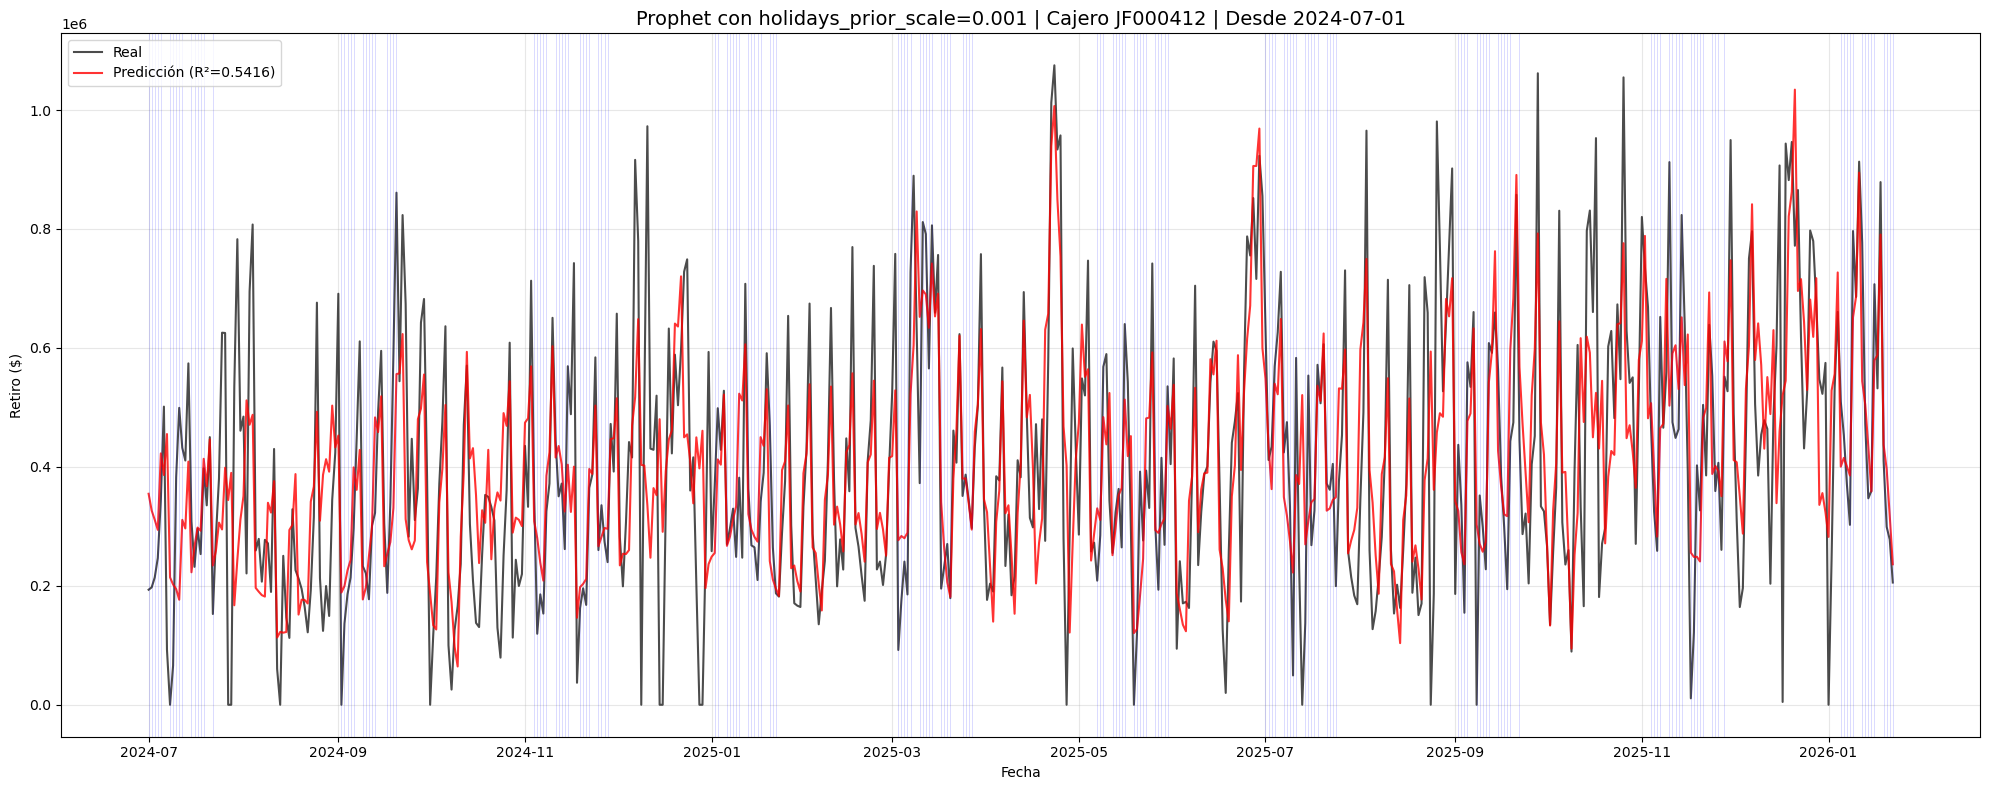

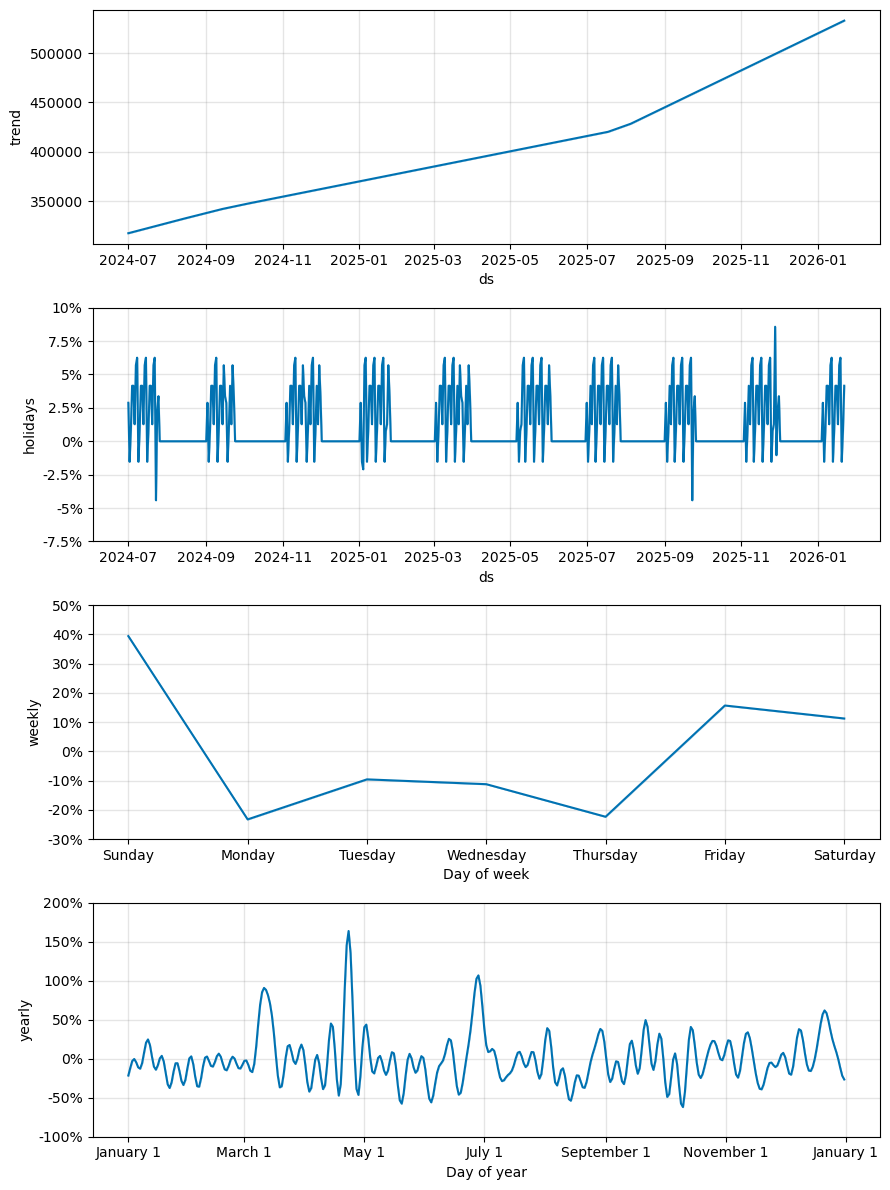


ANÁLISIS:
  Configuración óptima encontrada con Prophet:
    → holidays_type='agregado'
    → holidays_prior_scale=0.001
    → yearly_seasonality=12
    → R² máximo alcanzable: ~0.65
  Para mejorar más allá de este techo:
    → Considerar NeuralProphet (componente AR + no linealidad)


In [51]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# ============================================================
# 1. PREPARAR DATOS
# ============================================================
# Definir periodo de análisis y cajero a modelar
fecha_inicio = '2024-07-01'  # Inicio post-periodo electoral
cajero_test = 'JF000412'

# 2947

# Filtrar datos del cajero y periodo específico
df_cajero = df[(df['fecha'] >= fecha_inicio) & (df['cajero'] == cajero_test)][['fecha', 'retiro']].copy()
df_cajero.columns = ['ds', 'y']  # Prophet requiere columnas 'ds' (fecha) e 'y' (variable objetivo)
df_cajero = df_cajero.sort_values('ds').reset_index(drop=True)

print(f"Cajero {cajero_test}: {len(df_cajero)} observaciones desde {fecha_inicio}")
print(f"Rango: {df_cajero['ds'].min()} → {df_cajero['ds'].max()}")

# ============================================================
# 2. CONFIGURAR HOLIDAYS (FECHAS DE DISPERSIÓN)
# ============================================================
# Elegir nivel de granularidad de holidays:
# - 'granular': 54 eventos (adultos_mayores_A, adultos_mayores_B, etc.)
# - 'agregado': 3 eventos (adultos_mayores, discapacidad, madres_trabajadoras)
holidays_type = 'agregado' # agregado / granular
holidays_usar = holidays_df_granular if holidays_type == 'granular' else holidays_df_agregado

print(f"\nHolidays: {holidays_type}")
print(f"  Eventos únicos: {holidays_usar['holiday'].nunique()}")
print(f"  Total registros: {len(holidays_usar)}")

# ============================================================
# 3. CONFIGURAR MODELO PROPHET
# ============================================================
print("\n" + "="*80)
print("CONFIGURANDO MODELO PROPHET CON REGULARIZACIÓN BAJA EN HOLIDAYS")
print("="*80)

modelo = Prophet(
    # --- TENDENCIA ---
    growth='linear',                      # Tipo de tendencia: 'linear' (crecimiento lineal constante)
    changepoint_prior_scale=1,          # Flexibilidad de la tendencia (0.05=muy rígida, 0.5=flexible)
                                          # VALOR BALANCEADO: permite que la tendencia se adapte a cambios graduales
                                          # pero sin competir agresivamente con los holidays
    
    # --- ESTACIONALIDAD ANUAL ---
    yearly_seasonality=52,                # Términos de Fourier para capturar ciclo anual (12=patrón rico)
                                          # VALOR BALANCEADO: captura variaciones anuales sin sobre-ajustar
    seasonality_prior_scale=30,           # Regularización de estacionalidad (0.1=restrictiva, 10=flexible)
                                          # VALOR BALANCEADO: permite que estacionalidad contribuya sin dominar
    seasonality_mode='multiplicative',          # Modo aditivo: efectos se suman (vs 'multiplicative' que multiplica) additive / multiplicative
    
    # --- ESTACIONALIDADES SEMANAL Y DIARIA ---
    weekly_seasonality=True,              # Activada: puede haber patrón semanal leve
    daily_seasonality=False,              # Desactivada: no hay patrón intra-día en datos diarios
    
    # --- HOLIDAYS (DISPERSIONES) ---
    holidays=holidays_usar,               # Dataframe con fechas de dispersión y ventanas de efecto
    holidays_prior_scale=1,           # CLAVE: Regularización de holidays (0.001=casi sin restricción)
                                          # VALOR MUY BAJO: permite coeficientes masivos para capturar picos gigantes
                                          # Default es ~10, lo cual castiga coeficientes grandes y subestima picos
                                          # Este es el ÚNICO parámetro que debe estar muy bajo
    
    # --- INTERVALOS DE CONFIANZA ---
    interval_width=0.9                    # Ancho de intervalos de incertidumbre (90%)
)

print(f"\nParámetros configurados:")
print(f"  changepoint_prior_scale:  {modelo.changepoint_prior_scale} (flexible, balanceado)")
print(f"  seasonality_prior_scale:  {modelo.seasonality_prior_scale} (flexible, balanceado)")
print(f"  holidays_prior_scale:     {modelo.holidays_prior_scale} ← CLAVE: MUY BAJO PARA CAPTURAR PICOS")
print(f"  yearly_seasonality:       {modelo.yearly_seasonality} (rico)")
print(f"  Holidays únicos:          {holidays_usar['holiday'].nunique()}")

# ============================================================
# 4. ENTRENAR MODELO
# ============================================================
print("\nIniciando entrenamiento...")
modelo.fit(df_cajero)
print("Entrenamiento completado.")

# ============================================================
# 5. GENERAR PREDICCIONES
# ============================================================
forecast = modelo.predict(df_cajero)

# ============================================================
# 6. EVALUAR DESEMPEÑO
# ============================================================
# Unir predicciones con valores reales
merged = df_cajero.merge(forecast[['ds', 'yhat']], on='ds')

# ← NUEVO: Convertir predicciones negativas a cero
print("\nAplicando corrección: predicciones negativas → 0")
negativos_antes = (merged['yhat'] < 0).sum()
merged['yhat'] = merged['yhat'].clip(lower=0)  # Forzar mínimo en 0
print(f"  Predicciones negativas corregidas: {negativos_antes}")

# Calcular métricas
r2 = r2_score(merged['y'], merged['yhat'])
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(((merged['yhat'] - merged['y'])**2).mean())

print(f"\n{'='*80}")
print("RESULTADOS:")
print(f"  R² (coeficiente de determinación): {r2:.4f}")
print(f"     → % de varianza explicada por el modelo")
print(f"  MAE (error absoluto medio):        ${mae:,.0f}")
print(f"     → Error promedio en pesos")
print(f"  RMSE (raíz del error cuadrático): ${rmse:,.0f}")
print(f"     → Penaliza más los errores grandes")
print("="*80)

# ============================================================
# 7. GRAFICAR AJUSTE
# ============================================================
fig, ax = plt.subplots(figsize=(20, 8))

# Serie real (negro)
ax.plot(df_cajero['ds'], df_cajero['y'], 
        label='Real', color='black', linewidth=1.5, alpha=0.7)

# Predicción (rojo)
ax.plot(merged['ds'], merged['yhat'], 
        label=f'Predicción (R²={r2:.4f})', color='red', linewidth=1.5, alpha=0.8)

# Marcar fechas de dispersión (líneas verticales azules)
for fecha in holidays_usar['ds'].unique():
    if fecha >= df_cajero['ds'].min() and fecha <= df_cajero['ds'].max():
        ax.axvline(fecha, color='blue', alpha=0.2, linewidth=0.5)

ax.set_title(f'Prophet con holidays_prior_scale=0.001 | Cajero {cajero_test} | Desde {fecha_inicio}', 
             fontsize=14)
ax.set_xlabel('Fecha')
ax.set_ylabel('Retiro ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 8. GRAFICAR COMPONENTES DEL MODELO
# ============================================================
# Descomposición: tendencia + estacionalidad anual + efecto holidays
fig = modelo.plot_components(forecast)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANÁLISIS:")
print("  Configuración óptima encontrada con Prophet:")
print("    → holidays_type='agregado'")
print("    → holidays_prior_scale=0.001")
print("    → yearly_seasonality=12")
print("    → R² máximo alcanzable: ~0.65")
print("  Para mejorar más allá de este techo:")
print("    → Considerar NeuralProphet (componente AR + no linealidad)")
print("="*80)

Cajero JF002569: 509 observaciones desde 2024-09-01
Rango: 2024-09-01 00:00:00 → 2026-01-22 00:00:00

Holidays: agregado
  Eventos únicos: 3
  Total registros: 615

CONFIGURANDO MODELO PROPHET CON REGULARIZACIÓN BAJA EN HOLIDAYS

Parámetros configurados:
  changepoint_prior_scale:  1.0 (flexible, balanceado)
  seasonality_prior_scale:  30.0 (flexible, balanceado)
  holidays_prior_scale:     1.0 ← CLAVE: MUY BAJO PARA CAPTURAR PICOS
  yearly_seasonality:       52 (rico)
  Holidays únicos:          3

Iniciando entrenamiento...


10:47:52 - cmdstanpy - INFO - Chain [1] start processing
10:47:53 - cmdstanpy - INFO - Chain [1] done processing


Entrenamiento completado.

Aplicando corrección: predicciones negativas → 0
  Predicciones negativas corregidas: 8

RESULTADOS:
  R² (coeficiente de determinación): 0.7206
     → % de varianza explicada por el modelo
  MAE (error absoluto medio):        $43,091
     → Error promedio en pesos
  RMSE (raíz del error cuadrático): $63,856
     → Penaliza más los errores grandes


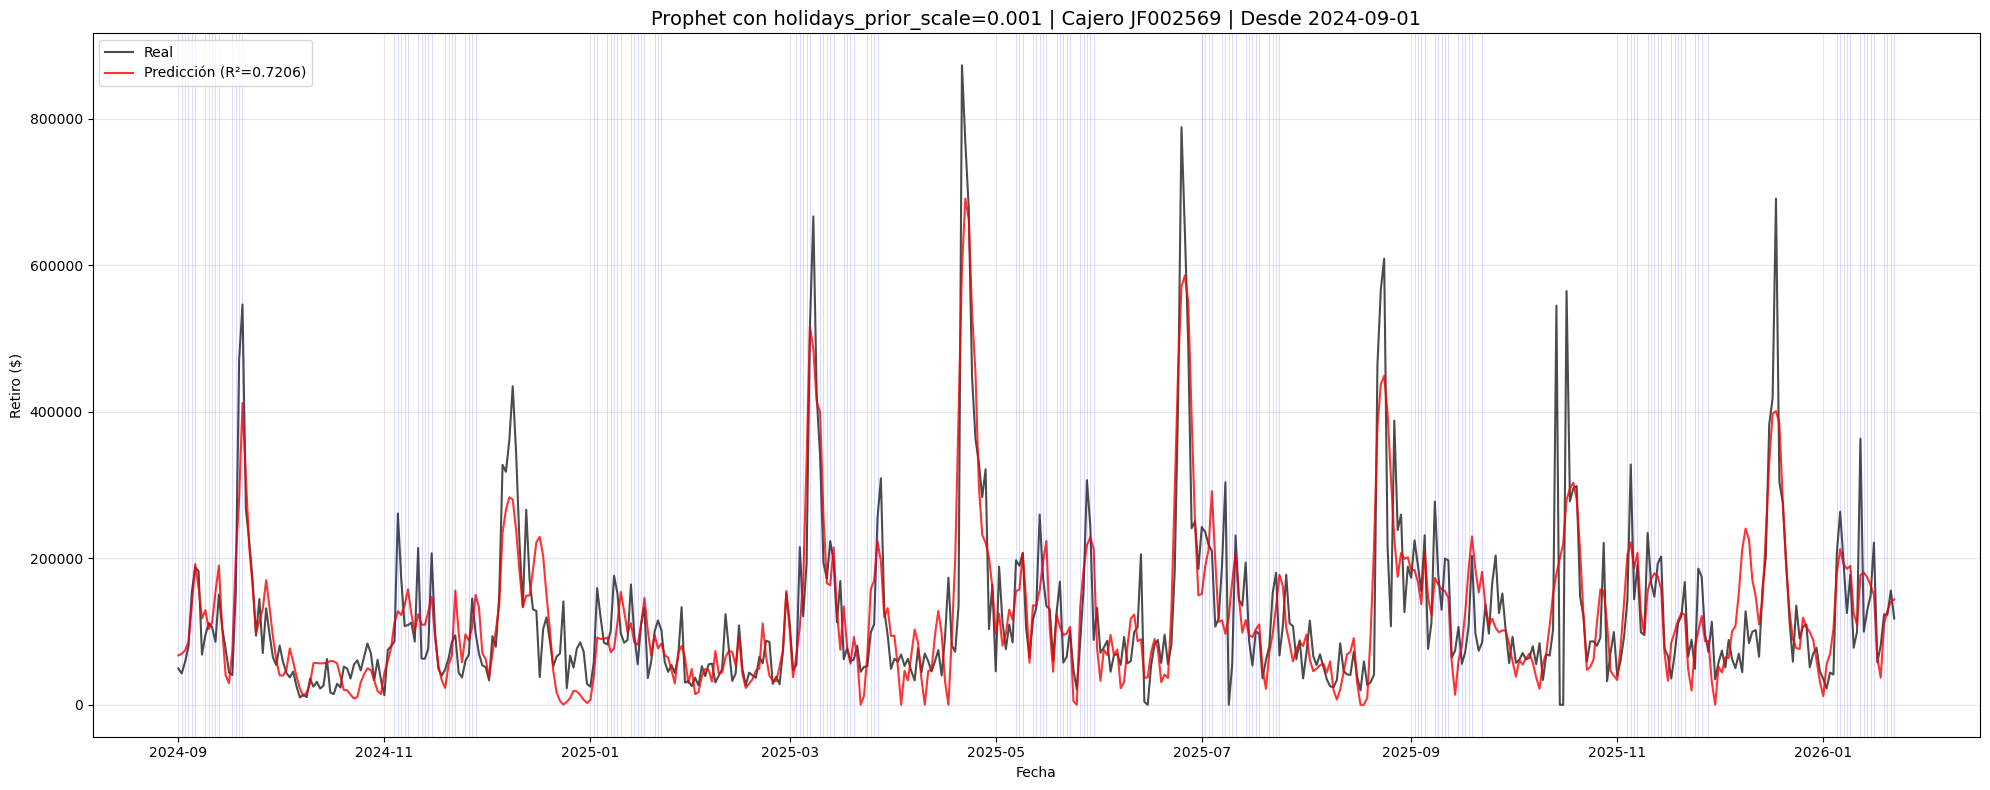

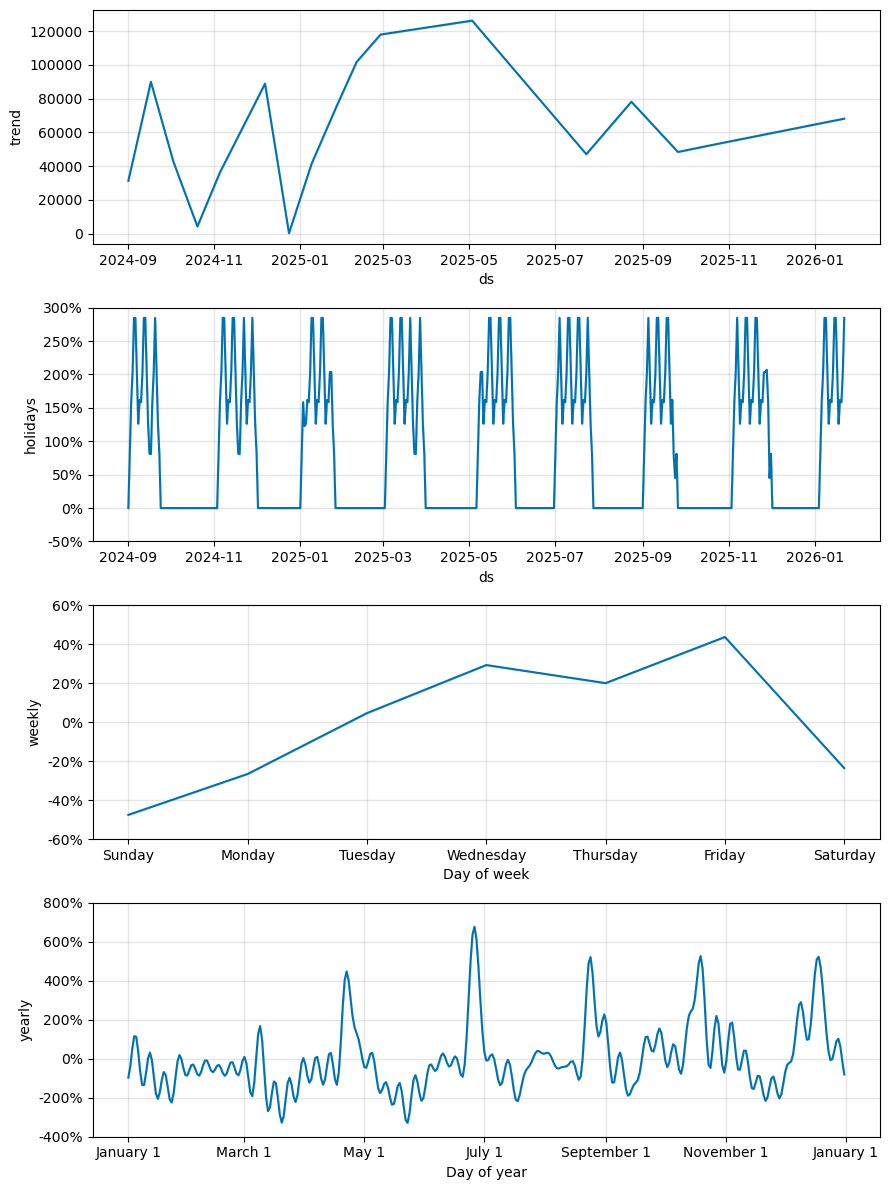


ANÁLISIS:
  Configuración óptima encontrada con Prophet:
    → holidays_type='agregado'
    → holidays_prior_scale=0.001
    → yearly_seasonality=12
    → R² máximo alcanzable: ~0.65
  Para mejorar más allá de este techo:
    → Considerar NeuralProphet (componente AR + no linealidad)


In [53]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# ============================================================
# 1. PREPARAR DATOS
# ============================================================
# Definir periodo de análisis y cajero a modelar
fecha_inicio = '2024-09-01'  # Inicio post-periodo electoral
cajero_test = 'JF002569'

# 2947

# Filtrar datos del cajero y periodo específico
df_cajero = df[(df['fecha'] >= fecha_inicio) & (df['cajero'] == cajero_test)][['fecha', 'retiro']].copy()
df_cajero.columns = ['ds', 'y']  # Prophet requiere columnas 'ds' (fecha) e 'y' (variable objetivo)
df_cajero = df_cajero.sort_values('ds').reset_index(drop=True)

print(f"Cajero {cajero_test}: {len(df_cajero)} observaciones desde {fecha_inicio}")
print(f"Rango: {df_cajero['ds'].min()} → {df_cajero['ds'].max()}")

# ============================================================
# 2. CONFIGURAR HOLIDAYS (FECHAS DE DISPERSIÓN)
# ============================================================
# Elegir nivel de granularidad de holidays:
# - 'granular': 54 eventos (adultos_mayores_A, adultos_mayores_B, etc.)
# - 'agregado': 3 eventos (adultos_mayores, discapacidad, madres_trabajadoras)
holidays_type = 'agregado' # agregado / granular
holidays_usar = holidays_df_granular if holidays_type == 'granular' else holidays_df_agregado

print(f"\nHolidays: {holidays_type}")
print(f"  Eventos únicos: {holidays_usar['holiday'].nunique()}")
print(f"  Total registros: {len(holidays_usar)}")

# ============================================================
# 3. CONFIGURAR MODELO PROPHET
# ============================================================
print("\n" + "="*80)
print("CONFIGURANDO MODELO PROPHET CON REGULARIZACIÓN BAJA EN HOLIDAYS")
print("="*80)

modelo = Prophet(
    # --- TENDENCIA ---
    growth='linear',                      # Tipo de tendencia: 'linear' (crecimiento lineal constante)
    changepoint_prior_scale=1,          # Flexibilidad de la tendencia (0.05=muy rígida, 0.5=flexible)
                                          # VALOR BALANCEADO: permite que la tendencia se adapte a cambios graduales
                                          # pero sin competir agresivamente con los holidays
    
    # --- ESTACIONALIDAD ANUAL ---
    yearly_seasonality=52,                # Términos de Fourier para capturar ciclo anual (12=patrón rico)
                                          # VALOR BALANCEADO: captura variaciones anuales sin sobre-ajustar
    seasonality_prior_scale=30,           # Regularización de estacionalidad (0.1=restrictiva, 10=flexible)
                                          # VALOR BALANCEADO: permite que estacionalidad contribuya sin dominar
    seasonality_mode='multiplicative',          # Modo aditivo: efectos se suman (vs 'multiplicative' que multiplica) additive / multiplicative
    
    # --- ESTACIONALIDADES SEMANAL Y DIARIA ---
    weekly_seasonality=True,              # Activada: puede haber patrón semanal leve
    daily_seasonality=False,              # Desactivada: no hay patrón intra-día en datos diarios
    
    # --- HOLIDAYS (DISPERSIONES) ---
    holidays=holidays_usar,               # Dataframe con fechas de dispersión y ventanas de efecto
    holidays_prior_scale=1,           # CLAVE: Regularización de holidays (0.001=casi sin restricción)
                                          # VALOR MUY BAJO: permite coeficientes masivos para capturar picos gigantes
                                          # Default es ~10, lo cual castiga coeficientes grandes y subestima picos
                                          # Este es el ÚNICO parámetro que debe estar muy bajo
    
    # --- INTERVALOS DE CONFIANZA ---
    interval_width=0.9                    # Ancho de intervalos de incertidumbre (90%)
)

print(f"\nParámetros configurados:")
print(f"  changepoint_prior_scale:  {modelo.changepoint_prior_scale} (flexible, balanceado)")
print(f"  seasonality_prior_scale:  {modelo.seasonality_prior_scale} (flexible, balanceado)")
print(f"  holidays_prior_scale:     {modelo.holidays_prior_scale} ← CLAVE: MUY BAJO PARA CAPTURAR PICOS")
print(f"  yearly_seasonality:       {modelo.yearly_seasonality} (rico)")
print(f"  Holidays únicos:          {holidays_usar['holiday'].nunique()}")

# ============================================================
# 4. ENTRENAR MODELO
# ============================================================
print("\nIniciando entrenamiento...")
modelo.fit(df_cajero)
print("Entrenamiento completado.")

# ============================================================
# 5. GENERAR PREDICCIONES
# ============================================================
forecast = modelo.predict(df_cajero)

# ============================================================
# 6. EVALUAR DESEMPEÑO
# ============================================================
# Unir predicciones con valores reales
merged = df_cajero.merge(forecast[['ds', 'yhat']], on='ds')

# ← NUEVO: Convertir predicciones negativas a cero
print("\nAplicando corrección: predicciones negativas → 0")
negativos_antes = (merged['yhat'] < 0).sum()
merged['yhat'] = merged['yhat'].clip(lower=0)  # Forzar mínimo en 0
print(f"  Predicciones negativas corregidas: {negativos_antes}")

# Calcular métricas
r2 = r2_score(merged['y'], merged['yhat'])
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(((merged['yhat'] - merged['y'])**2).mean())

print(f"\n{'='*80}")
print("RESULTADOS:")
print(f"  R² (coeficiente de determinación): {r2:.4f}")
print(f"     → % de varianza explicada por el modelo")
print(f"  MAE (error absoluto medio):        ${mae:,.0f}")
print(f"     → Error promedio en pesos")
print(f"  RMSE (raíz del error cuadrático): ${rmse:,.0f}")
print(f"     → Penaliza más los errores grandes")
print("="*80)

# ============================================================
# 7. GRAFICAR AJUSTE
# ============================================================
fig, ax = plt.subplots(figsize=(20, 8))

# Serie real (negro)
ax.plot(df_cajero['ds'], df_cajero['y'], 
        label='Real', color='black', linewidth=1.5, alpha=0.7)

# Predicción (rojo)
ax.plot(merged['ds'], merged['yhat'], 
        label=f'Predicción (R²={r2:.4f})', color='red', linewidth=1.5, alpha=0.8)

# Marcar fechas de dispersión (líneas verticales azules)
for fecha in holidays_usar['ds'].unique():
    if fecha >= df_cajero['ds'].min() and fecha <= df_cajero['ds'].max():
        ax.axvline(fecha, color='blue', alpha=0.2, linewidth=0.5)

ax.set_title(f'Prophet con holidays_prior_scale=0.001 | Cajero {cajero_test} | Desde {fecha_inicio}', 
             fontsize=14)
ax.set_xlabel('Fecha')
ax.set_ylabel('Retiro ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 8. GRAFICAR COMPONENTES DEL MODELO
# ============================================================
# Descomposición: tendencia + estacionalidad anual + efecto holidays
fig = modelo.plot_components(forecast)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANÁLISIS:")
print("  Configuración óptima encontrada con Prophet:")
print("    → holidays_type='agregado'")
print("    → holidays_prior_scale=0.001")
print("    → yearly_seasonality=12")
print("    → R² máximo alcanzable: ~0.65")
print("  Para mejorar más allá de este techo:")
print("    → Considerar NeuralProphet (componente AR + no linealidad)")
print("="*80)

Cajero JF002947: 571 observaciones desde 2024-07-01
Rango: 2024-07-01 00:00:00 → 2026-01-22 00:00:00

Holidays: agregado
  Eventos únicos: 3
  Total registros: 615

CONFIGURANDO MODELO PROPHET CON REGULARIZACIÓN BAJA EN HOLIDAYS

Parámetros configurados:
  changepoint_prior_scale:  1.0 (flexible, balanceado)
  seasonality_prior_scale:  30.0 (flexible, balanceado)
  holidays_prior_scale:     1.0 ← CLAVE: MUY BAJO PARA CAPTURAR PICOS
  yearly_seasonality:       52 (rico)
  Holidays únicos:          3

Iniciando entrenamiento...


10:57:26 - cmdstanpy - INFO - Chain [1] start processing
10:57:26 - cmdstanpy - INFO - Chain [1] done processing


Entrenamiento completado.

Aplicando corrección: predicciones negativas → 0
  Predicciones negativas corregidas: 3

RESULTADOS:
  R² (coeficiente de determinación): 0.7516
     → % de varianza explicada por el modelo
  MAE (error absoluto medio):        $35,902
     → Error promedio en pesos
  RMSE (raíz del error cuadrático): $50,289
     → Penaliza más los errores grandes


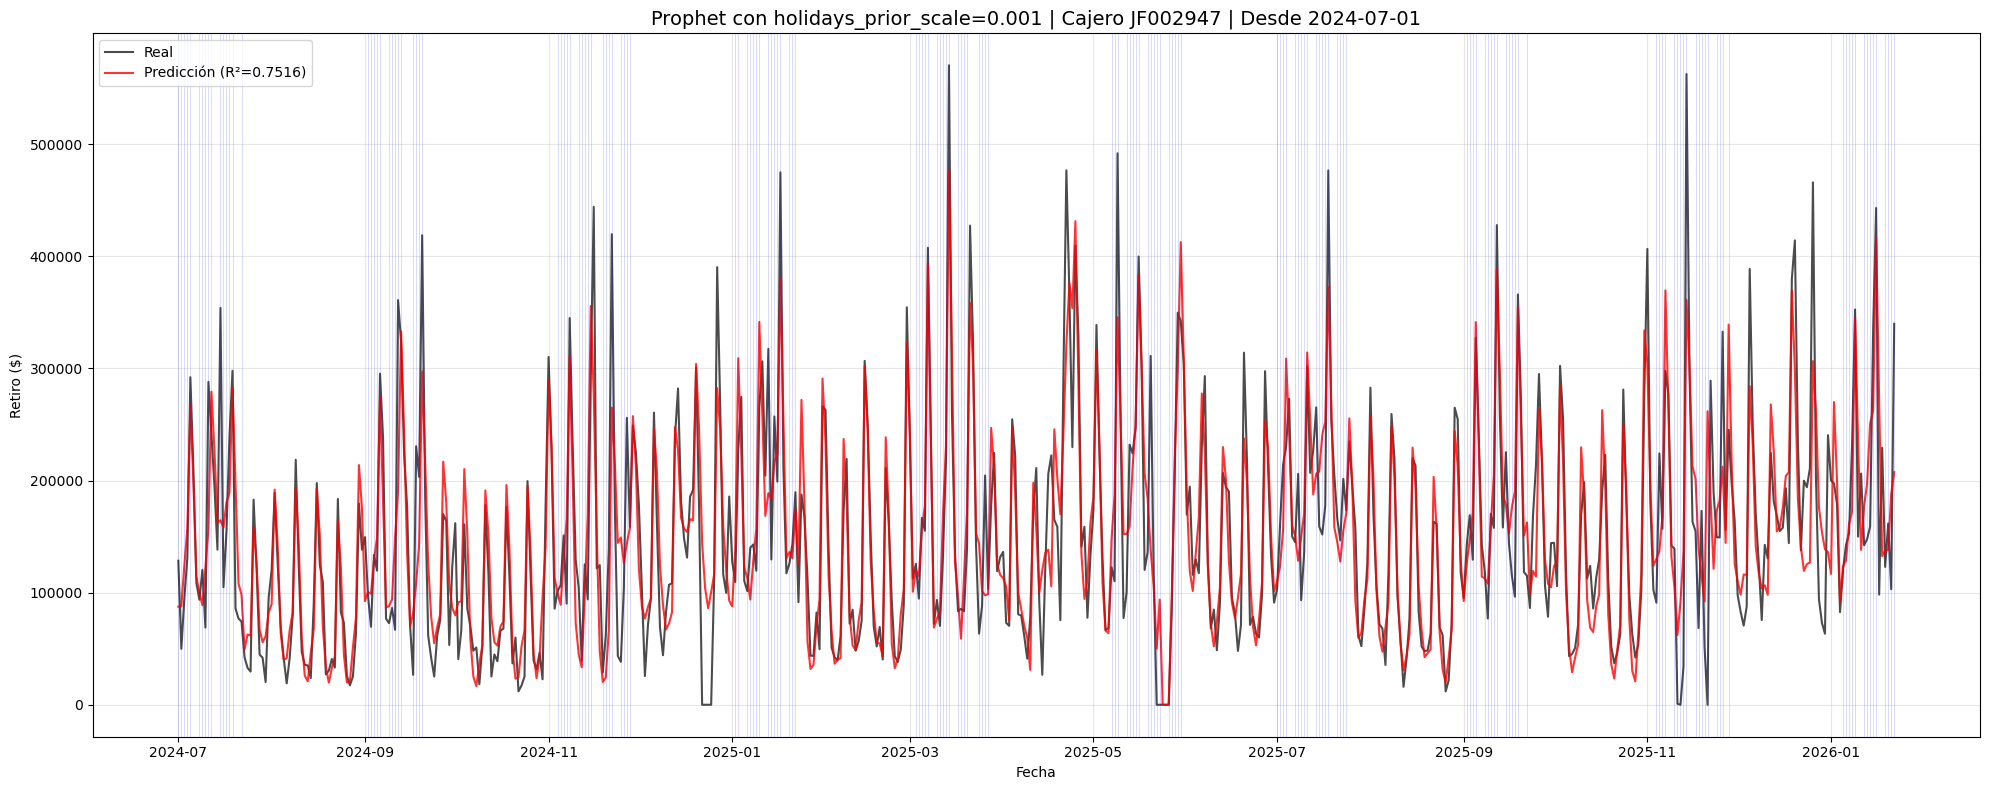

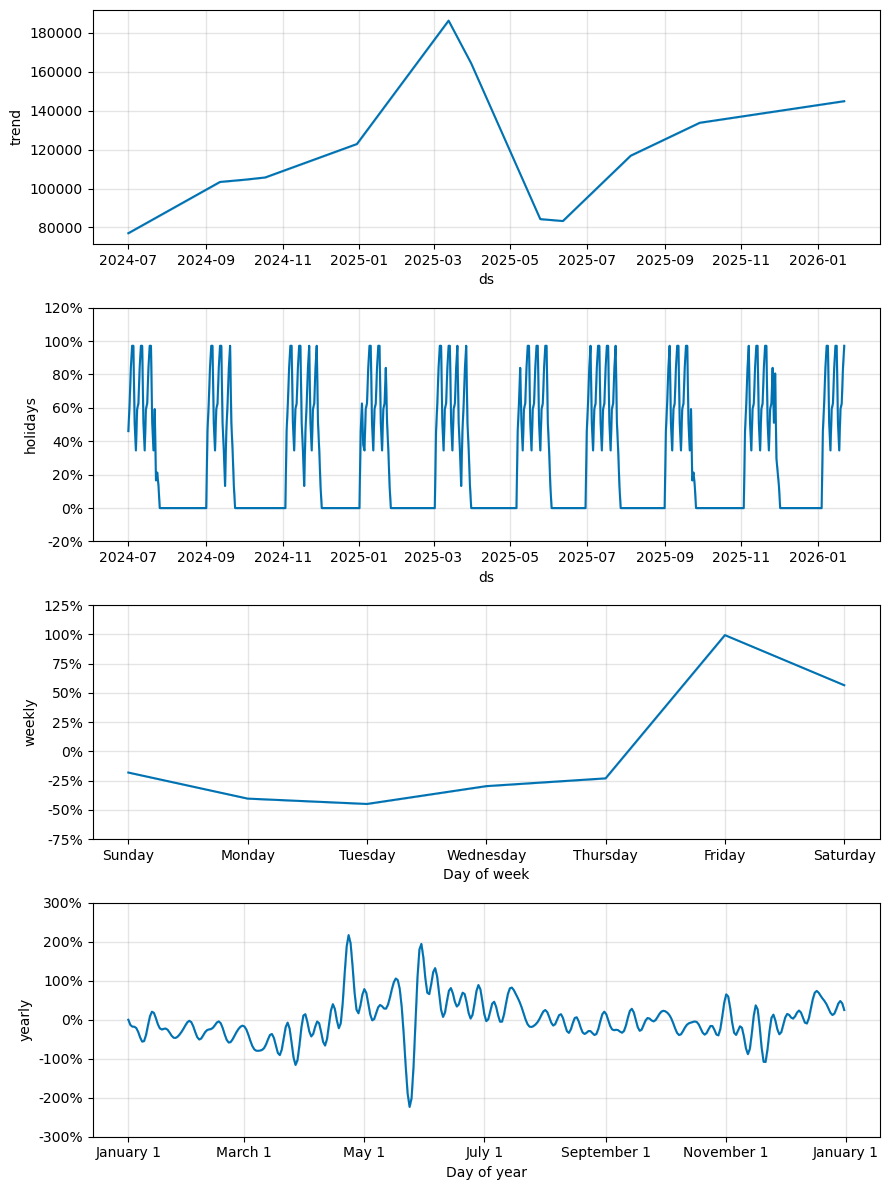


ANÁLISIS:
  Configuración óptima encontrada con Prophet:
    → holidays_type='agregado'
    → holidays_prior_scale=0.001
    → yearly_seasonality=12
    → R² máximo alcanzable: ~0.65
  Para mejorar más allá de este techo:
    → Considerar NeuralProphet (componente AR + no linealidad)


In [56]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# ============================================================
# 1. PREPARAR DATOS
# ============================================================
# Definir periodo de análisis y cajero a modelar
fecha_inicio = '2024-07-01'  # Inicio post-periodo electoral
cajero_test = 'JF002947'

# 2947

# Filtrar datos del cajero y periodo específico
df_cajero = df[(df['fecha'] >= fecha_inicio) & (df['cajero'] == cajero_test)][['fecha', 'retiro']].copy()
df_cajero.columns = ['ds', 'y']  # Prophet requiere columnas 'ds' (fecha) e 'y' (variable objetivo)
df_cajero = df_cajero.sort_values('ds').reset_index(drop=True)

print(f"Cajero {cajero_test}: {len(df_cajero)} observaciones desde {fecha_inicio}")
print(f"Rango: {df_cajero['ds'].min()} → {df_cajero['ds'].max()}")

# ============================================================
# 2. CONFIGURAR HOLIDAYS (FECHAS DE DISPERSIÓN)
# ============================================================
# Elegir nivel de granularidad de holidays:
# - 'granular': 54 eventos (adultos_mayores_A, adultos_mayores_B, etc.)
# - 'agregado': 3 eventos (adultos_mayores, discapacidad, madres_trabajadoras)
holidays_type = 'agregado' # agregado / granular
holidays_usar = holidays_df_granular if holidays_type == 'granular' else holidays_df_agregado

print(f"\nHolidays: {holidays_type}")
print(f"  Eventos únicos: {holidays_usar['holiday'].nunique()}")
print(f"  Total registros: {len(holidays_usar)}")

# ============================================================
# 3. CONFIGURAR MODELO PROPHET
# ============================================================
print("\n" + "="*80)
print("CONFIGURANDO MODELO PROPHET CON REGULARIZACIÓN BAJA EN HOLIDAYS")
print("="*80)

modelo = Prophet(
    # --- TENDENCIA ---
    growth='linear',                      # Tipo de tendencia: 'linear' (crecimiento lineal constante)
    changepoint_prior_scale=1,          # Flexibilidad de la tendencia (0.05=muy rígida, 0.5=flexible)
                                          # VALOR BALANCEADO: permite que la tendencia se adapte a cambios graduales
                                          # pero sin competir agresivamente con los holidays
    
    # --- ESTACIONALIDAD ANUAL ---
    yearly_seasonality=52,                # Términos de Fourier para capturar ciclo anual (12=patrón rico)
                                          # VALOR BALANCEADO: captura variaciones anuales sin sobre-ajustar
    seasonality_prior_scale=30,           # Regularización de estacionalidad (0.1=restrictiva, 10=flexible)
                                          # VALOR BALANCEADO: permite que estacionalidad contribuya sin dominar
    seasonality_mode='multiplicative',          # Modo aditivo: efectos se suman (vs 'multiplicative' que multiplica) additive / multiplicative
    
    # --- ESTACIONALIDADES SEMANAL Y DIARIA ---
    weekly_seasonality=True,              # Activada: puede haber patrón semanal leve
    daily_seasonality=False,              # Desactivada: no hay patrón intra-día en datos diarios
    
    # --- HOLIDAYS (DISPERSIONES) ---
    holidays=holidays_usar,               # Dataframe con fechas de dispersión y ventanas de efecto
    holidays_prior_scale=1,           # CLAVE: Regularización de holidays (0.001=casi sin restricción)
                                          # VALOR MUY BAJO: permite coeficientes masivos para capturar picos gigantes
                                          # Default es ~10, lo cual castiga coeficientes grandes y subestima picos
                                          # Este es el ÚNICO parámetro que debe estar muy bajo
    
    # --- INTERVALOS DE CONFIANZA ---
    interval_width=0.9                    # Ancho de intervalos de incertidumbre (90%)
)

print(f"\nParámetros configurados:")
print(f"  changepoint_prior_scale:  {modelo.changepoint_prior_scale} (flexible, balanceado)")
print(f"  seasonality_prior_scale:  {modelo.seasonality_prior_scale} (flexible, balanceado)")
print(f"  holidays_prior_scale:     {modelo.holidays_prior_scale} ← CLAVE: MUY BAJO PARA CAPTURAR PICOS")
print(f"  yearly_seasonality:       {modelo.yearly_seasonality} (rico)")
print(f"  Holidays únicos:          {holidays_usar['holiday'].nunique()}")

# ============================================================
# 4. ENTRENAR MODELO
# ============================================================
print("\nIniciando entrenamiento...")
modelo.fit(df_cajero)
print("Entrenamiento completado.")

# ============================================================
# 5. GENERAR PREDICCIONES
# ============================================================
forecast = modelo.predict(df_cajero)

# ============================================================
# 6. EVALUAR DESEMPEÑO
# ============================================================
# Unir predicciones con valores reales
merged = df_cajero.merge(forecast[['ds', 'yhat']], on='ds')

# ← NUEVO: Convertir predicciones negativas a cero
print("\nAplicando corrección: predicciones negativas → 0")
negativos_antes = (merged['yhat'] < 0).sum()
merged['yhat'] = merged['yhat'].clip(lower=0)  # Forzar mínimo en 0
print(f"  Predicciones negativas corregidas: {negativos_antes}")

# Calcular métricas
r2 = r2_score(merged['y'], merged['yhat'])
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(((merged['yhat'] - merged['y'])**2).mean())

print(f"\n{'='*80}")
print("RESULTADOS:")
print(f"  R² (coeficiente de determinación): {r2:.4f}")
print(f"     → % de varianza explicada por el modelo")
print(f"  MAE (error absoluto medio):        ${mae:,.0f}")
print(f"     → Error promedio en pesos")
print(f"  RMSE (raíz del error cuadrático): ${rmse:,.0f}")
print(f"     → Penaliza más los errores grandes")
print("="*80)

# ============================================================
# 7. GRAFICAR AJUSTE
# ============================================================
fig, ax = plt.subplots(figsize=(20, 8))

# Serie real (negro)
ax.plot(df_cajero['ds'], df_cajero['y'], 
        label='Real', color='black', linewidth=1.5, alpha=0.7)

# Predicción (rojo)
ax.plot(merged['ds'], merged['yhat'], 
        label=f'Predicción (R²={r2:.4f})', color='red', linewidth=1.5, alpha=0.8)

# Marcar fechas de dispersión (líneas verticales azules)
for fecha in holidays_usar['ds'].unique():
    if fecha >= df_cajero['ds'].min() and fecha <= df_cajero['ds'].max():
        ax.axvline(fecha, color='blue', alpha=0.2, linewidth=0.5)

ax.set_title(f'Prophet con holidays_prior_scale=0.001 | Cajero {cajero_test} | Desde {fecha_inicio}', 
             fontsize=14)
ax.set_xlabel('Fecha')
ax.set_ylabel('Retiro ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 8. GRAFICAR COMPONENTES DEL MODELO
# ============================================================
# Descomposición: tendencia + estacionalidad anual + efecto holidays
fig = modelo.plot_components(forecast)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANÁLISIS:")
print("  Configuración óptima encontrada con Prophet:")
print("    → holidays_type='agregado'")
print("    → holidays_prior_scale=0.001")
print("    → yearly_seasonality=12")
print("    → R² máximo alcanzable: ~0.65")
print("  Para mejorar más allá de este techo:")
print("    → Considerar NeuralProphet (componente AR + no linealidad)")
print("="*80)